In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

In [84]:
# trading day list
wind_trading_day = pd.read_csv(
    r"..\data\raw\meta_data\wind_trading_day.csv",
    index_col="Trading_Day",
    parse_dates=True,
)

In [85]:
# spread price continuous data
T_spread_price = pd.read_csv(
    "../data/processed/spread_price/T_spread_price.csv",
    index_col="Trading_Day",
    parse_dates=True,
)
TF_spread_price = pd.read_csv(
    "../data/processed/spread_price/TF_spread_price.csv",
    index_col="Trading_Day",
    parse_dates=True,
)

In [86]:
# start and end date of roll period
T_roll_period = pd.read_csv(
    "../data/processed/roll_period/T_roll_period.csv", index_col="contract"
).astype("datetime64[ns]")
TF_roll_period = pd.read_csv(
    "../data/processed/roll_period/TF_roll_period.csv", index_col="contract"
).astype("datetime64[ns]")

In [87]:
# close price continuous data
T_Close = pd.read_csv(
    "../data/interim/raw_features/T/T_Close.csv", index_col=0, parse_dates=True
)
TF_Close = pd.read_csv(
    "../data/interim/raw_features/TF/TF_Close.csv", index_col=0, parse_dates=True
)

In [88]:
# open interest continuous data
T_Open_Interest = pd.read_csv(
    "../data/interim/raw_features/T/T_Open_Interest.csv", 
    index_col=0, 
    parse_dates=True
)
TF_Open_Interest = pd.read_csv(
    "../data/interim/raw_features/TF/TF_Open_Interest.csv",
    index_col=0,
    parse_dates=True,
)

In [89]:
# volume continuous data
T_Volume = pd.read_csv(
    "../data/interim/raw_features/T/T_Volume.csv", index_col=0, parse_dates=True
)
TF_Volume = pd.read_csv(
    "../data/interim/raw_features/TF/TF_Volume.csv",
    index_col=0,
    parse_dates=True,
)

In [90]:
# list of contract by time sequence
T_contract_list = list(T_Close.columns)
TF_contract_list = list(TF_Close.columns)

In [91]:
def find_next_contract(contract, contract_list):

    contract_sr = pd.Series(index=contract_list)

    if contract in contract_list:
        return contract_sr[contract:].index[1]
    else:
        return None

In [92]:
def convert_to_intention_day(roll_period, wind_trading_day, last_record):
    
    # get the intention day(last day of roll period) of each contract 
    dominant_contract = pd.DataFrame(roll_period["end"].shift(-1))
    dominant_contract.columns = ["intention_day"]
    dominant_contract = dominant_contract.astype("datetime64[ns]")

    num_of_nan = dominant_contract.isna().sum().values[0]
    # delete future contracts
    if num_of_nan > 1:
        dominant_contract = dominant_contract.iloc[: (-1) * (num_of_nan - 1), :]

    dominant_contract = dominant_contract.fillna(last_record)
    # get the next date(notice day) after intention day
    dominant_contract["notice_day"] = [wind_trading_day.loc[x:].index[1] for x in dominant_contract.iloc[:, 0]]
    dominant_contract = dominant_contract.astype(str)

    return dominant_contract

In [93]:
def spread_change_during_roll(spread_price, roll_period, contract_list):

    # roll period from the aspect of active contract
    roll_period_for_active = roll_period.shift(-1).dropna()
    roll_period_for_active["spread_change"] = np.nan

    for active_contract in roll_period_for_active.index:
        # the deferred contract is the next contract after active contract
        deferred_contract = find_next_contract(active_contract, contract_list)
        start_date = roll_period_for_active.loc[active_contract, "start"]
        end_date = roll_period_for_active.loc[active_contract, "end"]
        # deferred contract becomes active after the roll period
        assert spread_price.loc[start_date, "active_contract"] == active_contract
        assert spread_price.loc[start_date, "deferred_contract"] == deferred_contract
        assert spread_price.loc[end_date, "active_contract"] == active_contract
        assert spread_price.loc[end_date, "deferred_contract"] == deferred_contract

        # spread change is the change of difference between acitve price and deferred price during the roll period
        spread_change = (spread_price.loc[end_date, "spread_price"] - spread_price.loc[start_date, "spread_price"])
        roll_period_for_active.loc[active_contract, "spread_change"] = spread_change
        spread_price.loc[start_date:end_date, "spread_price"].plot()
        plt.title(active_contract)
        plt.show()

    return pd.DataFrame(roll_period_for_active["spread_change"])

In [94]:
def treasury_futures_contracts_sequence(delivery_info):
    
    active_contracts = delivery_info.index.to_series()[:-1].values.reshape(-1, 1)
    deferred_contracts = delivery_info.index.to_series()[1:].values.reshape(-1, 1)
    # further contract is the next contract after deferred contract
    further_contracts = np.append(delivery_info.index.to_series().values[2:], None).reshape(-1, 1)
    
    notice_day = delivery_info["notice_day"].values[:-1].reshape(-1, 1)
    # gather info
    active_deferred_contracts = np.concatenate([active_contracts, deferred_contracts, further_contracts, notice_day], axis=1)
    # create dataframe
    contracts_sequence_df = pd.DataFrame(
        data=active_deferred_contracts,
        index=delivery_info["intention_day"][:-1],
        columns=[
            "active_contract",
            "deferred_contract",
            "further_contract",
            "notice_day",
        ],
    )

    return contracts_sequence_df

In [101]:
# get continuous data of the assigned value
def get_value_df(contracts_sequence, value, value_name, contract_list):

    value_df = pd.DataFrame(
        columns=[
            "active_contract",
            "deferred_contract",
            "further_contract",
            "active_contract_" + value_name,
            "deferred_contract_" + value_name,
            "further_contract_" + value_name,
        ]
    )
    # get the notice day of last active contract
    # if last active contract is the first contract, then the last notice day is the first trading day
    for i in range(len(contracts_sequence)):
        if i == 0:
            last_notice_day = value.index[0]
        else:
            last_notice_day = contracts_sequence["notice_day"][i - 1]

        intention_day = contracts_sequence.index[i]
        active_contract_code = contracts_sequence["active_contract"][i]
        deferred_contract_code = contracts_sequence["deferred_contract"][i]
        further_contract_code = contracts_sequence["further_contract"]
        
        # if the current active contract is not the last active contract, the contract is active from the last notice day to intention day
        if pd.to_datetime(intention_day) <= value.index[-1]:
            current_active_contract_value = value.loc[last_notice_day:intention_day, active_contract_code]
            current_deferred_contract_value = value.loc[last_notice_day:intention_day, deferred_contract_code]
            current_further_contract_value = value.loc[last_notice_day:intention_day, further_contract_code]
            active_contract_code_series = pd.Series(data=active_contract_code, index=current_active_contract_value.index)
            deferred_contract_code_series = pd.Series(data=deferred_contract_code, index=current_deferred_contract_value.index)
            further_contract_code_series = pd.Series(data=further_contract_code, index=current_further_contract_value.index)
        # if the last active contract in contracts sequence is the current active contract, the contract is active since the last notice day
        else:
            current_active_contract_value = value.loc[last_notice_day:, active_contract_code]
            current_deferred_contract_value = value.loc[last_notice_day:, deferred_contract_code]
            current_further_contract_value = value.loc[last_notice_day:, further_contract_code]

            if current_active_contract_value is not None: # check if there is any record of the last contract
                active_contract_code_series = pd.Series(data=active_contract_code, index=current_active_contract_value.index)
                deferred_contract_code_series = pd.Series(data=deferred_contract_code,index=current_deferred_contract_value.index)
                further_contract_code_series = pd.Series(data=further_contract_code,index=current_further_contract_value.index)

        current_data = pd.concat(
            [
                active_contract_code_series,
                deferred_contract_code_series,
                further_contract_code_series,
                current_active_contract_value,
                current_deferred_contract_value,
                current_further_contract_value,
            ],
            axis=1,
        )
        current_data.columns = value_df.columns
        value_df = pd.concat([value_df, current_data], axis=0)

    last_intention_date = pd.to_datetime(intention_day)
    # if the last contract is not the current active contract, that means the current contract is not in the active contract list
    # add information about the current active contract and corresponding deferred contract
    if last_intention_date < value.index[-1]:

        current_contract = contracts_sequence.loc[intention_day, "deferred_contract"]
        next_contract = find_next_contract(current_contract, contract_list)
        further_contract = find_next_contract(next_contract, contract_list)

        latest_active_contract_value = value.loc[last_intention_date:, current_contract].iloc[1:]
        latest_deferred_contract_value = value.loc[last_intention_date:, next_contract].iloc[1:]
        latest_further_contract_value = value.loc[last_intention_date:, further_contract].iloc[1:]

        active_contract_code_series = pd.Series(data=current_contract, index=latest_active_contract_value.index)
        deferred_contract_code_series = pd.Series(data=next_contract, index=latest_deferred_contract_value.index)
        further_contract_code_series = pd.Series(data=further_contract, index=latest_further_contract_value.index)

        current_data = pd.concat(
            [
                active_contract_code_series,
                deferred_contract_code_series,
                further_contract_code_series,
                latest_active_contract_value,
                latest_deferred_contract_value,
                latest_further_contract_value,
            ],
            axis=1,
        )
        current_data.columns = value_df.columns

        value_df = pd.concat([value_df, current_data], axis=0)

    value_df.index.name = "Trading_Day"

    return value_df

In [96]:
T_dominant_contract

,intention_day,notice_day
contract,,
T1509,2015-08-19,2015-08-20
T1512,2015-11-20,2015-11-23
T1603,2016-02-19,2016-02-22
T1606,2016-05-12,2016-05-13
T1609,2016-08-16,2016-08-17
T1612,2016-11-10,2016-11-11
T1703,2017-02-09,2017-02-10
T1706,2017-05-15,2017-05-16
T1709,2017-08-10,2017-08-11


In [97]:
T_roll_period["end"].shift(-1)

contract
T1509   2015-08-19
T1512   2015-11-20
T1603   2016-02-19
T1606   2016-05-12
T1609   2016-08-16
T1612   2016-11-10
T1703   2017-02-09
T1706   2017-05-15
T1709   2017-08-10
T1712   2017-11-14
T1803   2018-02-12
T1806   2018-05-21
T1809   2018-08-20
T1812   2018-11-16
T1903   2019-02-25
T1906   2019-05-29
T1909          NaT
T1912          NaT
Name: end, dtype: datetime64[ns]

In [98]:
T_last_record = T_Close.index[-1]
T_dominant_contract = convert_to_intention_day(
    T_roll_period, wind_trading_day, T_last_record
)
TF_last_record = TF_Close.index[-1]
TF_dominant_contract = convert_to_intention_day(
    TF_roll_period, wind_trading_day, TF_last_record
)

T_contracts_sequence = treasury_futures_contracts_sequence(T_dominant_contract)
TF_contracts_sequence = treasury_futures_contracts_sequence(TF_dominant_contract)

## Spread Price Change

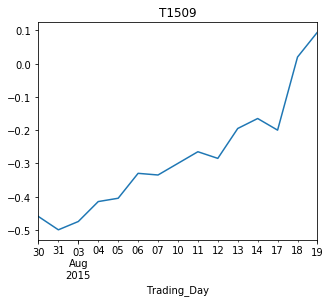

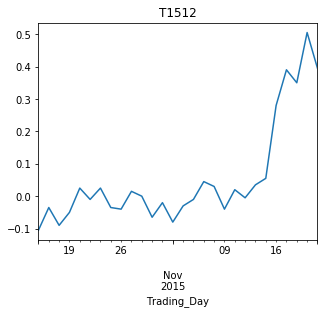

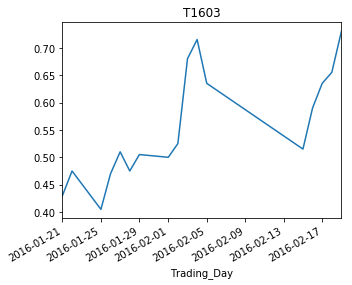

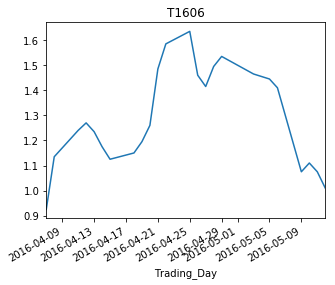

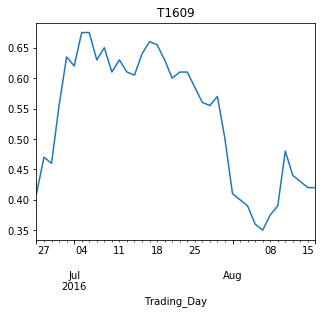

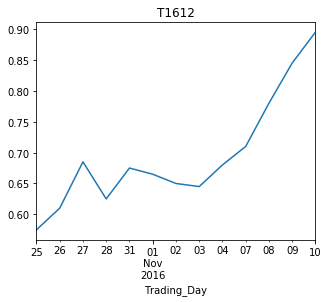

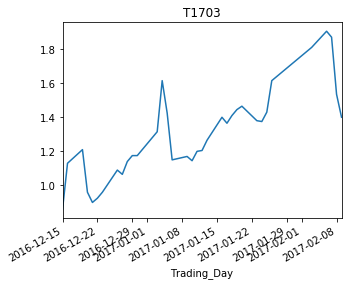

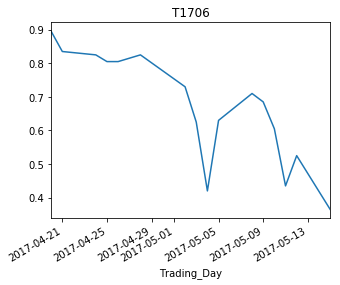

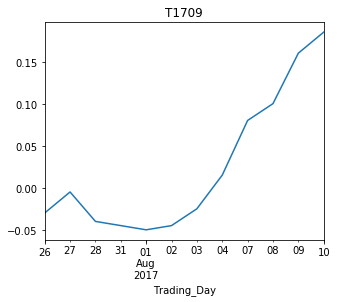

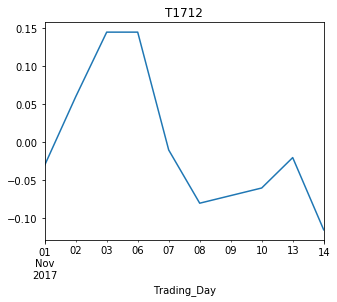

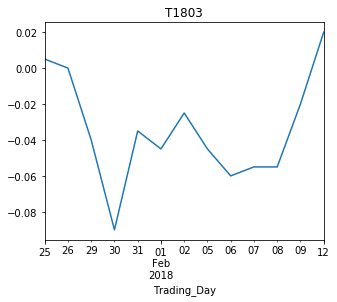

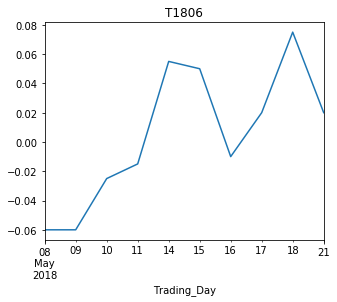

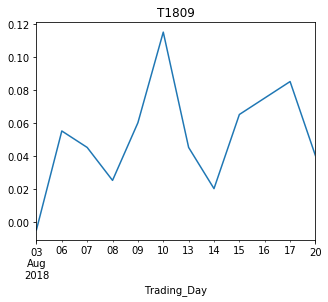

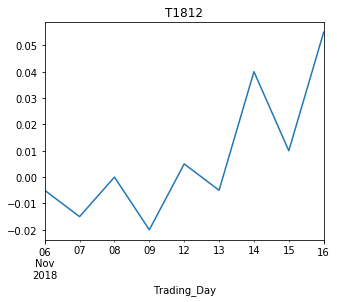

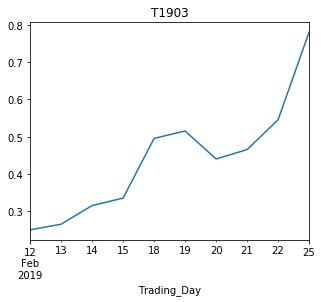

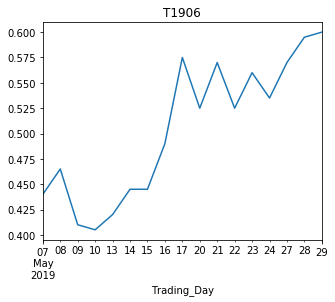

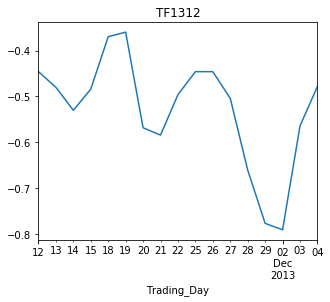

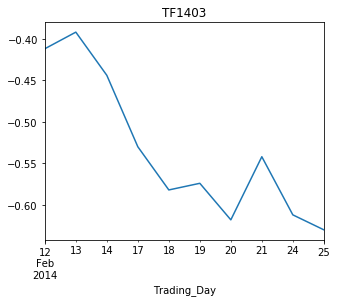

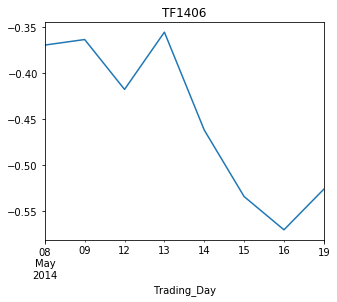

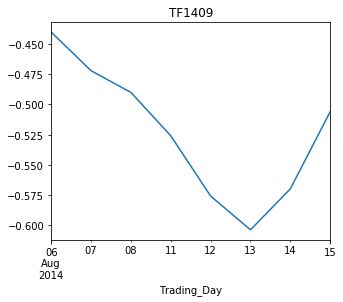

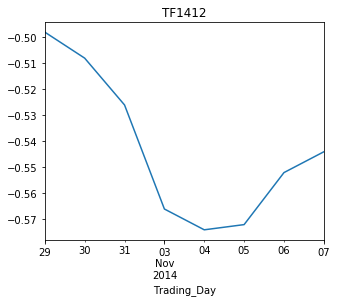

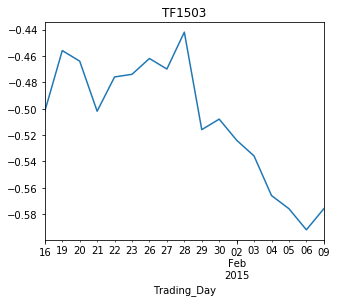

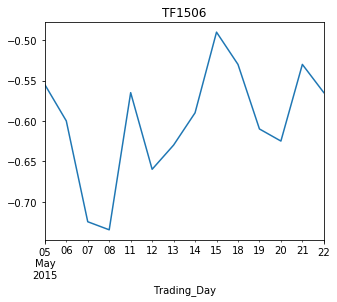

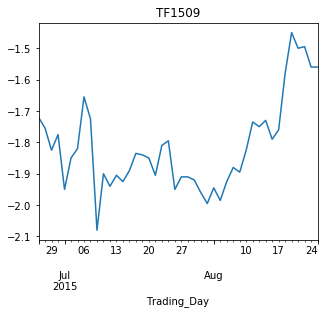

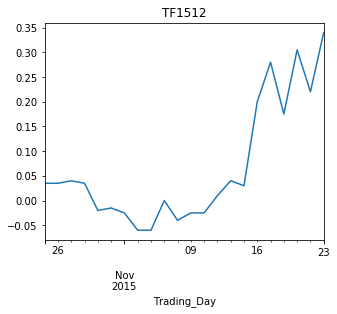

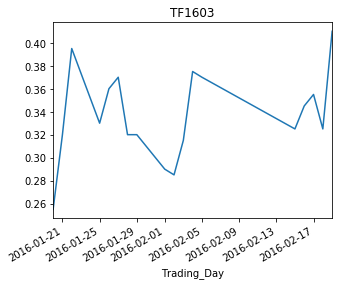

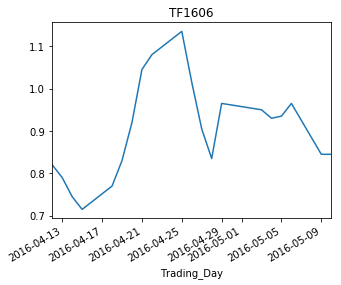

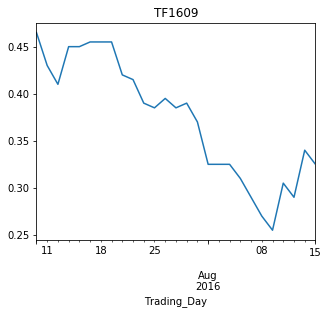

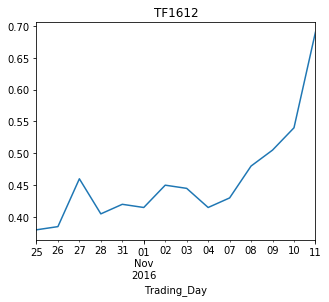

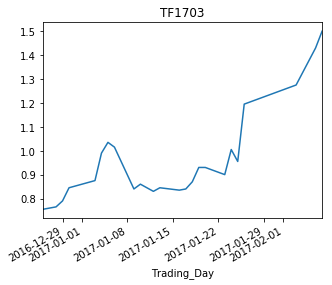

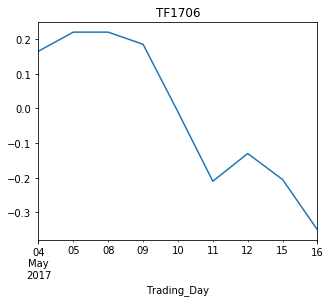

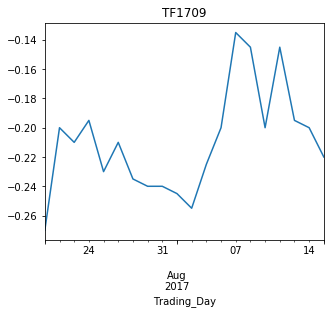

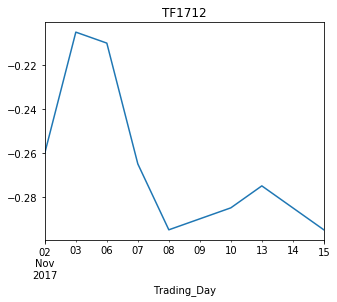

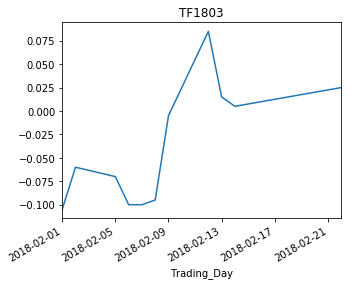

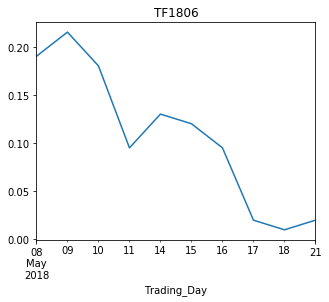

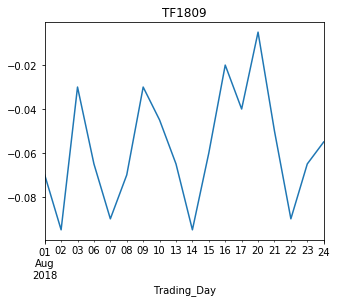

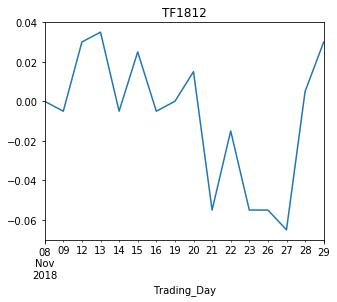

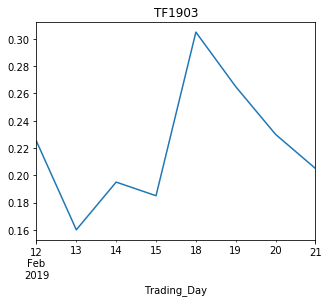

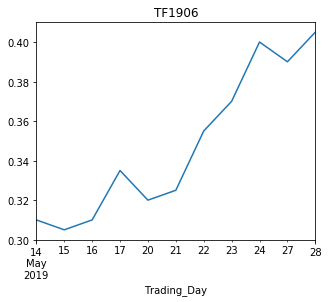

In [17]:
T_spread_change = spread_change_during_roll(
    T_spread_price, T_roll_period, T_contract_list
)
TF_spread_change = spread_change_during_roll(
    TF_spread_price, TF_roll_period, TF_contract_list
)

## Create Feature DataFrame

In [16]:
T_features = pd.DataFrame()
TF_features = pd.DataFrame()

In [17]:
# add new feature to the feature dataframe, if the feature already exists, replace it with the new value
def add_feature(features, new_feature):
    if new_feature.columns[0] not in features.columns:
        features = pd.concat([features, new_feature], axis=1)
    else:
        features = features.drop(new_feature.columns[0], axis=1)
        features = pd.concat([features, new_feature], axis=1)
        
    return features

## 1 Spread 5d Change

In [99]:
# calculate the spread change right before roll period of the assigned length
def spread_change_before_roll(days, spread_price, roll_period, contract_list):
    
    roll_period_for_active = roll_period.shift(-1).dropna()
    roll_period_for_active[str(days) + "d_spread_change"] = np.nan

    for active_contract in roll_period_for_active.index:

        deferred_contract = find_next_contract(active_contract, contract_list)
        # the start date of the roll period, in this case, it is the last date of the considered period
        start_date = roll_period_for_active.loc[active_contract, "start"]
        # the begin date of the considered period, days means days before the roll period
        begin_date = spread_price.loc[:start_date, :].index[-1 * days]

        assert spread_price.loc[begin_date, "active_contract"] == active_contract
        assert spread_price.loc[begin_date, "deferred_contract"] == deferred_contract
        assert spread_price.loc[start_date, "active_contract"] == active_contract
        assert spread_price.loc[start_date, "deferred_contract"] == deferred_contract
        # the change of spread during the period
        spread_change = (spread_price.loc[start_date, "spread_price"] - spread_price.loc[begin_date, "spread_price"])
        roll_period_for_active.loc[active_contract, str(days) + "d_spread_change"] = spread_change

    return pd.DataFrame(roll_period_for_active[str(days) + "d_spread_change"])

In [102]:
# get the continuous price
T_price_conti = get_value_df(T_contracts_sequence, T_Close, "price", T_contract_list)
T_price_conti["spread_price"] = T_price_conti["deferred_contract_price"] - T_price_conti["active_contract_price"]
T_price_conti.head()

ValueError: Location based indexing can only have [labels (MUST BE IN THE INDEX), slices of labels (BOTH endpoints included! Can be slices of integers if the index is integers), listlike of labels, boolean] types

In [20]:
T_spread_5d_change = spread_change_before_roll(
    5, T_price_conti, T_roll_period, T_contract_list
)
T_spread_10d_change = spread_change_before_roll(
    10, T_price_conti, T_roll_period, T_contract_list
)
T_spread_15d_change = spread_change_before_roll(
    15, T_price_conti, T_roll_period, T_contract_list
)
T_spread_20d_change = spread_change_before_roll(
    20, T_price_conti, T_roll_period, T_contract_list
)

In [22]:
TF_price_conti = get_value_df(
    TF_contracts_sequence, TF_Close, "price", TF_contract_list
)
TF_price_conti["spread_price"] = (
    TF_price_conti["deferred_contract_price"]
    - TF_price_conti["active_contract_price"]
)
TF_price_conti.head()

,active_contract,deferred_contract,further_contract,active_contract_price,deferred_contract_price,further_contract_price,spread_price
Trading_Day,,,,,,,
2013-09-06,TF1312,TF1403,TF1406,94.170,94.288,94.344,0.118
2013-09-09,TF1312,TF1403,TF1406,93.906,94.000,94.070,0.094
2013-09-10,TF1312,TF1403,TF1406,93.842,93.930,94.008,0.088
2013-09-11,TF1312,TF1403,TF1406,93.598,93.688,93.766,0.090
2013-09-12,TF1312,TF1403,TF1406,93.728,93.842,93.926,0.114


In [23]:
TF_spread_5d_change = spread_change_before_roll(
    5, TF_price_conti, TF_roll_period, TF_contract_list
)
TF_spread_10d_change = spread_change_before_roll(
    10, TF_price_conti, TF_roll_period, TF_contract_list
)
TF_spread_15d_change = spread_change_before_roll(
    15, TF_price_conti, TF_roll_period, TF_contract_list
)
TF_spread_20d_change = spread_change_before_roll(
    20, TF_price_conti, TF_roll_period, TF_contract_list
)

In [24]:
T_features = add_feature(T_features, T_spread_5d_change)
TF_features = add_feature(TF_features, TF_spread_5d_change)
T_features

,5d_spread_change
contract,
T1509,-0.040
T1512,0.110
T1603,-0.070
T1606,-0.095
T1609,0.185
T1612,-0.215
T1703,-0.185
T1706,-0.100
T1709,0.050


## 2 Act Price 10d Exp Mva

In [25]:
# calculate the exponential moving average 
def exp_mva(days, price, roll_period, contract_list, name):
    # including price on that day
    price_emva = price.ewm(span=days).mean()

    roll_period_for_active = roll_period.shift(-1).dropna()
    roll_period_for_active[str(days) + name] = np.nan

    for active_contract in roll_period_for_active.index:

        deferred_contract = find_next_contract(active_contract, contract_list)
        start_date = roll_period_for_active.loc[active_contract, "start"]

        roll_period_for_active.loc[active_contract, str(days) + name] = price_emva[start_date]

    return pd.DataFrame(roll_period_for_active[str(days) + name])

In [26]:
# calculate 10 days exponential moving average of the active price
T_act_price_10d_exp_mva = exp_mva(
    10, 
    T_price_conti["active_contract_price"], 
    T_roll_period, 
    T_contract_list,
    'd_act_price_exp_mva'
)

TF_act_price_10d_exp_mva = exp_mva(
    10, 
    TF_price_conti["active_contract_price"], 
    TF_roll_period, 
    TF_contract_list,
    'd_act_price_exp_mva'
)

In [27]:
T_features = add_feature(T_features, T_act_price_10d_exp_mva)
TF_features = add_feature(TF_features, TF_act_price_10d_exp_mva)
T_features

,5d_spread_change,10d_act_price_exp_mva
contract,,
T1509,-0.040,95.894291
T1512,0.110,97.764844
T1603,-0.070,100.309110
T1606,-0.095,99.660441
T1609,0.185,99.727908
T1612,-0.215,101.577332
T1703,-0.185,96.911919
T1706,-0.100,96.450696
T1709,0.050,95.171014


## 3 Corr Btwn Act Price and Def OI

In [28]:
# correlation between two time series
def corr(days, var1, var2, roll_period, contract_list, name):

    roll_period_for_active = roll_period.shift(-1).dropna()
    roll_period_for_active[str(days) + name] = np.nan

    for active_contract in roll_period_for_active.index:

        deferred_contract = find_next_contract(active_contract, contract_list)
        last_date = roll_period.loc[active_contract, "end"]  # last date of last active period
        start_date = roll_period_for_active.loc[active_contract, "start"]  # start date of this roll period
        begin_date = var1[last_date:start_date].index[-1 * days]  # begin date of the considered period
        # calculate the correlation whenm the considered contract is active
        corr = var1[begin_date:start_date].corr(var2[begin_date:start_date])
        roll_period_for_active.loc[active_contract, str(days) + name] = corr

    return pd.DataFrame(roll_period_for_active[str(days) + name])

In [29]:
# get the continuous open interest data
T_OI_conti = get_value_df(T_contracts_sequence, T_Open_Interest, "OI", T_contract_list)
TF_OI_conti = get_value_df(
    TF_contracts_sequence, TF_Open_Interest, "OI", TF_contract_list
)

In [30]:
# calculate correlation between active price and deferred open interest
T_corr_act_price_def_OI = corr(
    -1,
    T_price_conti["active_contract_price"],
    T_OI_conti["deferred_contract_OI"],
    T_roll_period,
    T_contract_list,
    "d_corr_act_price_def_OI"
)

In [31]:
TF_corr_act_price_def_OI = corr(
    -1, 
    TF_price_conti['active_contract_price'],                           
    TF_OI_conti['deferred_contract_OI'], 
    TF_roll_period, 
    TF_contract_list,
    "d_corr_act_price_def_OI"
)

In [32]:
T_features = add_feature(T_features, T_corr_act_price_def_OI)
TF_features = add_feature(TF_features, TF_corr_act_price_def_OI)
T_features

,5d_spread_change,10d_act_price_exp_mva,-1d_corr_act_price_def_OI
contract,,,
T1509,-0.040,95.894291,-0.359839
T1512,0.110,97.764844,0.709530
T1603,-0.070,100.309110,0.868510
T1606,-0.095,99.660441,0.298564
T1609,0.185,99.727908,0.834111
T1612,-0.215,101.577332,0.556915
T1703,-0.185,96.911919,-0.985163
T1706,-0.100,96.450696,0.768958
T1709,0.050,95.171014,0.268659


## 4 Corr Btwn Def Price and Def OI

In [33]:
# calculate correlation between deferred price and deferred open interest
T_corr_def_price_def_OI = corr(
    -1,
    T_price_conti["deferred_contract_price"],
    T_OI_conti["deferred_contract_OI"],
    T_roll_period,
    T_contract_list,
    "d_corr_def_price_def_OI"
)

In [34]:
TF_corr_def_price_def_OI = corr(
    -1, 
    TF_price_conti['deferred_contract_price'],                           
    TF_OI_conti['deferred_contract_OI'], 
    TF_roll_period, 
    TF_contract_list,
    "d_corr_def_price_def_OI"
)

In [35]:
T_features = add_feature(T_features, T_corr_def_price_def_OI)
TF_features = add_feature(TF_features, TF_corr_def_price_def_OI)
T_features

,5d_spread_change,10d_act_price_exp_mva,-1d_corr_act_price_def_OI,-1d_corr_def_price_def_OI
contract,,,,
T1509,-0.040,95.894291,-0.359839,-0.367154
T1512,0.110,97.764844,0.709530,0.699821
T1603,-0.070,100.309110,0.868510,0.820498
T1606,-0.095,99.660441,0.298564,-0.082451
T1609,0.185,99.727908,0.834111,0.912053
T1612,-0.215,101.577332,0.556915,0.515826
T1703,-0.185,96.911919,-0.985163,-0.988359
T1706,-0.100,96.450696,0.768958,0.797022
T1709,0.050,95.171014,0.268659,0.345207


## 5 Spread Std10 Divided by Std

In [36]:
# calculate the n days standard deviation of the time series
# if divide is true, the result should be divided by its expanding standard deviation
def ndays_std(days, var, roll_period, contract_list, name, divide=True):
    
    roll_period_for_active = roll_period.shift(-1).dropna()
    roll_period_for_active[str(days)+name] = np.nan
    
    for active_contract in roll_period_for_active.index:      

        deferred_contract = find_next_contract(active_contract, contract_list)
        
        last_date = roll_period.loc[active_contract, "end"]# last date of last active period
        start_date = roll_period_for_active.loc[active_contract, 'start']# start date of this roll period
        begin_date = var[last_date:start_date].index[-1*days]# begin date of the considered period
        first_date = var[last_date:].index[1]# begin date of the expanding period
        # std of n days period 
        ndays_std = var[begin_date:start_date].std()
        
        if divide:
            ndays_std = ndays_std / var[first_date:start_date].std() # divide by the std of the expanding period
            
        roll_period_for_active.loc[active_contract, str(days)+name] = ndays_std
        
    return pd.DataFrame(roll_period_for_active[str(days)+name])

In [37]:
T_std10_divided_by_std = ndays_std(10, T_price_conti['spread_price'], T_roll_period, T_contract_list, 'd_spread_std_divided_by_std')

In [38]:
TF_std10_divided_by_std = ndays_std(10, TF_price_conti['spread_price'], TF_roll_period, TF_contract_list, 'd_spread_std_divided_by_std')

In [39]:
T_features = add_feature(T_features, T_std10_divided_by_std)
TF_features = add_feature(TF_features, TF_std10_divided_by_std)
T_features

,5d_spread_change,10d_act_price_exp_mva,-1d_corr_act_price_def_OI,-1d_corr_def_price_def_OI,10d_spread_std_divided_by_std
contract,,,,,
T1509,-0.040,95.894291,-0.359839,-0.367154,0.241032
T1512,0.110,97.764844,0.709530,0.699821,0.499298
T1603,-0.070,100.309110,0.868510,0.820498,0.864757
T1606,-0.095,99.660441,0.298564,-0.082451,0.353565
T1609,0.185,99.727908,0.834111,0.912053,0.823588
T1612,-0.215,101.577332,0.556915,0.515826,1.817464
T1703,-0.185,96.911919,-0.985163,-0.988359,0.730805
T1706,-0.100,96.450696,0.768958,0.797022,0.514090
T1709,0.050,95.171014,0.268659,0.345207,0.334610


## 6 Act Price Current Value Divided by 10d Mva

In [40]:
# calculate the current value of the considered variable
# if divide is true, the value is divided by n days moving average right before the rolling period
def current_value(days, var, roll_period, contract_list, name, divide=True):
    
    roll_period_for_active = roll_period.shift(-1).dropna()
    roll_period_for_active[str(days)+name] = np.nan
    
    for active_contract in roll_period_for_active.index:      

        deferred_contract = find_next_contract(active_contract, contract_list)

        start_date = roll_period_for_active.loc[active_contract, 'start']# start date of this roll period
        begin_date = var[:start_date].index[-1*days]# begin date of the considered period
        
        ndays_mva = var[begin_date:start_date].mean()# average value n days right before the roll period
        
        current_var = var[start_date]
        
        if divide:
            current_var = current_var / ndays_mva
            
        roll_period_for_active.loc[active_contract, str(days)+name] = current_var
        
    return pd.DataFrame(roll_period_for_active[str(days)+name])

In [41]:
T_current_price = current_value(10, T_price_conti['active_contract_price'], T_roll_period, T_contract_list, 'd_current_price')

In [42]:
TF_current_price = current_value(10, TF_price_conti['active_contract_price'], TF_roll_period, TF_contract_list, 'd_current_price')

In [43]:
T_features = add_feature(T_features, T_current_price)
TF_features = add_feature(TF_features, TF_current_price)
T_features

,5d_spread_change,10d_act_price_exp_mva,-1d_corr_act_price_def_OI,-1d_corr_def_price_def_OI,10d_spread_std_divided_by_std,10d_current_price
contract,,,,,,
T1509,-0.040,95.894291,-0.359839,-0.367154,0.241032,1.001200
T1512,0.110,97.764844,0.709530,0.699821,0.499298,1.011756
T1603,-0.070,100.309110,0.868510,0.820498,0.864757,0.999602
T1606,-0.095,99.660441,0.298564,-0.082451,0.353565,0.997503
T1609,0.185,99.727908,0.834111,0.912053,0.823588,1.004593
T1612,-0.215,101.577332,0.556915,0.515826,1.817464,0.999208
T1703,-0.185,96.911919,-0.985163,-0.988359,0.730805,0.973670
T1706,-0.100,96.450696,0.768958,0.797022,0.514090,0.996314
T1709,0.050,95.171014,0.268659,0.345207,0.334610,0.995999


## 7 Z Diff Act Price Def Price

In [44]:
def cal_zscore(var):
    return pd.Series((var - var.mean()) / var.std(), index=var.index)

In [45]:
# difference of two variables' z-scores
def Z_diff(days, var1, var2, roll_period, contract_list, name):
    
    roll_period_for_active = roll_period.shift(-1).dropna()
    roll_period_for_active[str(days)+name] = np.nan
    
    for active_contract in roll_period_for_active.index:      

        deferred_contract = find_next_contract(active_contract, contract_list)
        
        last_date = roll_period.loc[active_contract, "end"]# last date of last active period
        start_date = roll_period_for_active.loc[active_contract, 'start']# start date of this roll period
        begin_date = var1[last_date:start_date].index[-1*days]# begin date of the considered period
        
        z_diff = cal_zscore(var1)[begin_date:start_date] - cal_zscore(var2)[begin_date:start_date]# z-score difference
        
        roll_period_for_active.loc[active_contract, str(days)+name] = z_diff.mean()# average over the considered period
        
    return pd.DataFrame(roll_period_for_active[str(days)+name])

In [46]:
T_z_diff_act_price_def_price = Z_diff(
    1, 
    T_price_conti['active_contract_price'], 
    T_price_conti['deferred_contract_price'], 
    T_roll_period, 
    T_contract_list,
    'd_z_diff_act_price_def_price'
)

In [47]:
TF_z_diff_act_price_def_price = Z_diff(
    1, 
    TF_price_conti['active_contract_price'], 
    TF_price_conti['deferred_contract_price'], 
    TF_roll_period, 
    TF_contract_list,
    'd_z_diff_act_price_def_price'
)

In [48]:
T_features = add_feature(T_features, T_z_diff_act_price_def_price)
TF_features = add_feature(TF_features, TF_z_diff_act_price_def_price)
T_features

,5d_spread_change,10d_act_price_exp_mva,-1d_corr_act_price_def_OI,-1d_corr_def_price_def_OI,10d_spread_std_divided_by_std,10d_current_price,1d_z_diff_act_price_def_price
contract,,,,,,,
T1509,-0.040,95.894291,-0.359839,-0.367154,0.241032,1.001200,-0.280154
T1512,0.110,97.764844,0.709530,0.699821,0.499298,1.011756,-0.212655
T1603,-0.070,100.309110,0.868510,0.820498,0.864757,0.999602,-0.030646
T1606,-0.095,99.660441,0.298564,-0.082451,0.353565,0.997503,0.216248
T1609,0.185,99.727908,0.834111,0.912053,0.823588,1.004593,-0.032958
T1612,-0.215,101.577332,0.556915,0.515826,1.817464,0.999208,-0.003657
T1703,-0.185,96.911919,-0.985163,-0.988359,0.730805,0.973670,0.347428
T1706,-0.100,96.450696,0.768958,0.797022,0.514090,0.996314,0.308599
T1709,0.050,95.171014,0.268659,0.345207,0.334610,0.995999,-0.054089


## 8 Corr Btwn Act Price and Def TTotVlm

In [49]:
T_volume_conti = get_value_df(T_contracts_sequence, T_Volume, "volume", T_contract_list)
TF_volume_conti = get_value_df(TF_contracts_sequence, TF_Volume, "volume", TF_contract_list)

In [50]:
T_corr_act_price_def_volume = corr(
    -1,
    T_price_conti["active_contract_price"],
    T_volume_conti["deferred_contract_volume"],
    T_roll_period,
    T_contract_list,
    'd_corr_act_price_def_volume'
)

In [51]:
TF_corr_act_price_def_volume = corr(
    -1,
    TF_price_conti["active_contract_price"],
    TF_volume_conti["deferred_contract_volume"],
    TF_roll_period,
    TF_contract_list,
    'd_corr_act_price_def_volume'
)

In [52]:
T_features = add_feature(T_features, T_corr_act_price_def_volume)
TF_features = add_feature(TF_features, TF_corr_act_price_def_volume)
T_features

,5d_spread_change,10d_act_price_exp_mva,-1d_corr_act_price_def_OI,-1d_corr_def_price_def_OI,10d_spread_std_divided_by_std,10d_current_price,1d_z_diff_act_price_def_price,-1d_corr_act_price_def_volume
contract,,,,,,,,
T1509,-0.040,95.894291,-0.359839,-0.367154,0.241032,1.001200,-0.280154,-0.277585
T1512,0.110,97.764844,0.709530,0.699821,0.499298,1.011756,-0.212655,0.529342
T1603,-0.070,100.309110,0.868510,0.820498,0.864757,0.999602,-0.030646,0.694754
T1606,-0.095,99.660441,0.298564,-0.082451,0.353565,0.997503,0.216248,-0.332806
T1609,0.185,99.727908,0.834111,0.912053,0.823588,1.004593,-0.032958,0.789217
T1612,-0.215,101.577332,0.556915,0.515826,1.817464,0.999208,-0.003657,0.395675
T1703,-0.185,96.911919,-0.985163,-0.988359,0.730805,0.973670,0.347428,-0.854435
T1706,-0.100,96.450696,0.768958,0.797022,0.514090,0.996314,0.308599,0.656255
T1709,0.050,95.171014,0.268659,0.345207,0.334610,0.995999,-0.054089,0.170932


## 9 Corr Btwn Def Price and Def TTotVlm

In [53]:
T_corr_def_price_def_volume = corr(
    -1,
    T_price_conti["deferred_contract_price"],
    T_volume_conti["deferred_contract_volume"],
    T_roll_period,
    T_contract_list,
    'd_corr_def_price_def_volume'
)

In [54]:
TF_corr_def_price_def_volume = corr(
    -1,
    TF_price_conti["deferred_contract_price"],
    TF_volume_conti["deferred_contract_volume"],
    TF_roll_period,
    TF_contract_list,
    'd_corr_def_price_def_volume'
)

In [55]:
T_features = add_feature(T_features, T_corr_def_price_def_volume)
TF_features = add_feature(TF_features, TF_corr_def_price_def_volume)
T_features

,5d_spread_change,10d_act_price_exp_mva,-1d_corr_act_price_def_OI,-1d_corr_def_price_def_OI,10d_spread_std_divided_by_std,10d_current_price,1d_z_diff_act_price_def_price,-1d_corr_act_price_def_volume,-1d_corr_def_price_def_volume
contract,,,,,,,,,
T1509,-0.040,95.894291,-0.359839,-0.367154,0.241032,1.001200,-0.280154,-0.277585,-0.271916
T1512,0.110,97.764844,0.709530,0.699821,0.499298,1.011756,-0.212655,0.529342,0.538683
T1603,-0.070,100.309110,0.868510,0.820498,0.864757,0.999602,-0.030646,0.694754,0.648495
T1606,-0.095,99.660441,0.298564,-0.082451,0.353565,0.997503,0.216248,-0.332806,-0.525496
T1609,0.185,99.727908,0.834111,0.912053,0.823588,1.004593,-0.032958,0.789217,0.808561
T1612,-0.215,101.577332,0.556915,0.515826,1.817464,0.999208,-0.003657,0.395675,0.304910
T1703,-0.185,96.911919,-0.985163,-0.988359,0.730805,0.973670,0.347428,-0.854435,-0.854991
T1706,-0.100,96.450696,0.768958,0.797022,0.514090,0.996314,0.308599,0.656255,0.668624
T1709,0.050,95.171014,0.268659,0.345207,0.334610,0.995999,-0.054089,0.170932,0.250544


## 10 Spread Current Value Divided by 10d Mva

In [56]:
T_current_spread = current_value(10, T_price_conti['spread_price'], T_roll_period, T_contract_list, 'd_current_spread')

In [57]:
TF_current_spread = current_value(10, TF_price_conti['spread_price'], TF_roll_period, TF_contract_list, 'd_current_spread')

In [58]:
T_features = add_feature(T_features, T_current_spread)
TF_features = add_feature(TF_features, TF_current_spread)
T_features

,5d_spread_change,10d_act_price_exp_mva,-1d_corr_act_price_def_OI,-1d_corr_def_price_def_OI,10d_spread_std_divided_by_std,10d_current_price,1d_z_diff_act_price_def_price,-1d_corr_act_price_def_volume,-1d_corr_def_price_def_volume,10d_current_spread
contract,,,,,,,,,,
T1509,-0.040,95.894291,-0.359839,-0.367154,0.241032,1.001200,-0.280154,-0.277585,-0.271916,1.024499
T1512,0.110,97.764844,0.709530,0.699821,0.499298,1.011756,-0.212655,0.529342,0.538683,5.526316
T1603,-0.070,100.309110,0.868510,0.820498,0.864757,0.999602,-0.030646,0.694754,0.648495,1.376000
T1606,-0.095,99.660441,0.298564,-0.082451,0.353565,0.997503,0.216248,-0.332806,-0.525496,1.136364
T1609,0.185,99.727908,0.834111,0.912053,0.823588,1.004593,-0.032958,0.789217,0.808561,0.659694
T1612,-0.215,101.577332,0.556915,0.515826,1.817464,0.999208,-0.003657,0.395675,0.304910,1.387214
T1703,-0.185,96.911919,-0.985163,-0.988359,0.730805,0.973670,0.347428,-0.854435,-0.854991,1.203639
T1706,-0.100,96.450696,0.768958,0.797022,0.514090,0.996314,0.308599,0.656255,0.668624,1.002801
T1709,0.050,95.171014,0.268659,0.345207,0.334610,0.995999,-0.054089,0.170932,0.250544,-7.500000


## 11 Def Price Std

In [59]:
# calculate standard deviation of price
def cal_std(days, var, roll_period, contract_list):
    
    roll_period_for_active = roll_period.shift(-1).dropna()
    roll_period_for_active[str(days)+'d_std'] = np.nan
    
    for active_contract in roll_period_for_active.index:
        
        deferred_contract = find_next_contract(active_contract, contract_list)
        
        last_date = roll_period.loc[active_contract, "end"]# end date of last rolling period
        start_date = roll_period_for_active.loc[active_contract, 'start']# start date of this rolling period
        begin_date = var[last_date:start_date].index[-1*days]# begin date of the considered period
        
        std = var[begin_date:start_date].std()
        
        roll_period_for_active.loc[active_contract, str(days)+'d_std'] = std
        
    return pd.DataFrame(roll_period_for_active[str(days)+'d_std'])

In [60]:
T_def_price_std = cal_std(-1, T_price_conti['deferred_contract_price'], T_roll_period, T_contract_list)

In [61]:
TF_def_price_std = cal_std(-1, TF_price_conti['deferred_contract_price'], TF_roll_period, TF_contract_list)

In [62]:
T_features = add_feature(T_features, T_def_price_std)
TF_features = add_feature(TF_features, TF_def_price_std)
T_features

,5d_spread_change,10d_act_price_exp_mva,-1d_corr_act_price_def_OI,-1d_corr_def_price_def_OI,10d_spread_std_divided_by_std,10d_current_price,1d_z_diff_act_price_def_price,-1d_corr_act_price_def_volume,-1d_corr_def_price_def_volume,10d_current_spread,-1d_std
contract,,,,,,,,,,,
T1509,-0.040,95.894291,-0.359839,-0.367154,0.241032,1.001200,-0.280154,-0.277585,-0.271916,1.024499,0.938507
T1512,0.110,97.764844,0.709530,0.699821,0.499298,1.011756,-0.212655,0.529342,0.538683,5.526316,0.765108
T1603,-0.070,100.309110,0.868510,0.820498,0.864757,0.999602,-0.030646,0.694754,0.648495,1.376000,0.634708
T1606,-0.095,99.660441,0.298564,-0.082451,0.353565,0.997503,0.216248,-0.332806,-0.525496,1.136364,0.316857
T1609,0.185,99.727908,0.834111,0.912053,0.823588,1.004593,-0.032958,0.789217,0.808561,0.659694,0.513632
T1612,-0.215,101.577332,0.556915,0.515826,1.817464,0.999208,-0.003657,0.395675,0.304910,1.387214,0.343909
T1703,-0.185,96.911919,-0.985163,-0.988359,0.730805,0.973670,0.347428,-0.854435,-0.854991,1.203639,1.459897
T1706,-0.100,96.450696,0.768958,0.797022,0.514090,0.996314,0.308599,0.656255,0.668624,1.002801,0.950219
T1709,0.050,95.171014,0.268659,0.345207,0.334610,0.995999,-0.054089,0.170932,0.250544,-7.500000,0.460466


## 12 Corr Btwn Act Price and Def Price

In [63]:
T_corr_act_price_def_price = corr(
    -1,
    T_price_conti["active_contract_price"],
    T_price_conti["deferred_contract_price"],
    T_roll_period,
    T_contract_list,
    'd_corr_act_price_def_price'
)

In [64]:
TF_corr_act_price_def_price = corr(
    -1,
    TF_price_conti["active_contract_price"],
    TF_price_conti["deferred_contract_price"],
    TF_roll_period,
    TF_contract_list,
    'd_corr_act_price_def_price'
)

In [65]:
T_features = add_feature(T_features, T_corr_act_price_def_price)
TF_features = add_feature(TF_features, TF_corr_act_price_def_price)
T_features

,5d_spread_change,10d_act_price_exp_mva,-1d_corr_act_price_def_OI,-1d_corr_def_price_def_OI,10d_spread_std_divided_by_std,10d_current_price,1d_z_diff_act_price_def_price,-1d_corr_act_price_def_volume,-1d_corr_def_price_def_volume,10d_current_spread,-1d_std,-1d_corr_act_price_def_price
contract,,,,,,,,,,,,
T1509,-0.040,95.894291,-0.359839,-0.367154,0.241032,1.001200,-0.280154,-0.277585,-0.271916,1.024499,0.938507,0.992453
T1512,0.110,97.764844,0.709530,0.699821,0.499298,1.011756,-0.212655,0.529342,0.538683,5.526316,0.765108,0.995892
T1603,-0.070,100.309110,0.868510,0.820498,0.864757,0.999602,-0.030646,0.694754,0.648495,1.376000,0.634708,0.994081
T1606,-0.095,99.660441,0.298564,-0.082451,0.353565,0.997503,0.216248,-0.332806,-0.525496,1.136364,0.316857,0.898696
T1609,0.185,99.727908,0.834111,0.912053,0.823588,1.004593,-0.032958,0.789217,0.808561,0.659694,0.513632,0.984116
T1612,-0.215,101.577332,0.556915,0.515826,1.817464,0.999208,-0.003657,0.395675,0.304910,1.387214,0.343909,0.993301
T1703,-0.185,96.911919,-0.985163,-0.988359,0.730805,0.973670,0.347428,-0.854435,-0.854991,1.203639,1.459897,0.997803
T1706,-0.100,96.450696,0.768958,0.797022,0.514090,0.996314,0.308599,0.656255,0.668624,1.002801,0.950219,0.995399
T1709,0.050,95.171014,0.268659,0.345207,0.334610,0.995999,-0.054089,0.170932,0.250544,-7.500000,0.460466,0.987217


## 13 Corr Btwn Act OI and Def TTotVlm

In [66]:
T_corr_act_OI_def_volume = corr(
    -1,
    T_OI_conti["active_contract_OI"],
    T_volume_conti["deferred_contract_volume"],
    T_roll_period,
    T_contract_list,
    'd_corr_act_OI_def_volume'
)

In [67]:
TF_corr_act_OI_def_volume = corr(
    -1,
    TF_OI_conti["active_contract_OI"],
    TF_volume_conti["deferred_contract_volume"],
    TF_roll_period,
    TF_contract_list,
    'd_corr_act_OI_def_volume'
)

In [68]:
T_features = add_feature(T_features, T_corr_act_OI_def_volume)
TF_features = add_feature(TF_features, TF_corr_act_OI_def_volume)
T_features

,5d_spread_change,10d_act_price_exp_mva,-1d_corr_act_price_def_OI,-1d_corr_def_price_def_OI,10d_spread_std_divided_by_std,10d_current_price,1d_z_diff_act_price_def_price,-1d_corr_act_price_def_volume,-1d_corr_def_price_def_volume,10d_current_spread,-1d_std,-1d_corr_act_price_def_price,-1d_corr_act_OI_def_volume
contract,,,,,,,,,,,,,
T1509,-0.040,95.894291,-0.359839,-0.367154,0.241032,1.001200,-0.280154,-0.277585,-0.271916,1.024499,0.938507,0.992453,0.327061
T1512,0.110,97.764844,0.709530,0.699821,0.499298,1.011756,-0.212655,0.529342,0.538683,5.526316,0.765108,0.995892,0.088638
T1603,-0.070,100.309110,0.868510,0.820498,0.864757,0.999602,-0.030646,0.694754,0.648495,1.376000,0.634708,0.994081,0.701297
T1606,-0.095,99.660441,0.298564,-0.082451,0.353565,0.997503,0.216248,-0.332806,-0.525496,1.136364,0.316857,0.898696,0.295250
T1609,0.185,99.727908,0.834111,0.912053,0.823588,1.004593,-0.032958,0.789217,0.808561,0.659694,0.513632,0.984116,0.381061
T1612,-0.215,101.577332,0.556915,0.515826,1.817464,0.999208,-0.003657,0.395675,0.304910,1.387214,0.343909,0.993301,0.251675
T1703,-0.185,96.911919,-0.985163,-0.988359,0.730805,0.973670,0.347428,-0.854435,-0.854991,1.203639,1.459897,0.997803,0.314522
T1706,-0.100,96.450696,0.768958,0.797022,0.514090,0.996314,0.308599,0.656255,0.668624,1.002801,0.950219,0.995399,-0.050479
T1709,0.050,95.171014,0.268659,0.345207,0.334610,0.995999,-0.054089,0.170932,0.250544,-7.500000,0.460466,0.987217,-0.631705


## 14 Corr Btwn Act OI and Def OI

In [69]:
T_corr_act_OI_def_OI = corr(
    -1,
    T_OI_conti["active_contract_OI"],
    T_OI_conti["deferred_contract_OI"],
    T_roll_period,
    T_contract_list,
    'd_corr_act_OI_def_OI'
)

In [70]:
TF_corr_act_OI_def_OI = corr(
    -1,
    TF_OI_conti["active_contract_OI"],
    TF_OI_conti["deferred_contract_OI"],
    TF_roll_period,
    TF_contract_list,
    'd_corr_act_OI_def_OI'
)

In [71]:
T_features = add_feature(T_features, T_corr_act_OI_def_OI)
TF_features = add_feature(TF_features, TF_corr_act_OI_def_OI)
T_features

,5d_spread_change,10d_act_price_exp_mva,-1d_corr_act_price_def_OI,-1d_corr_def_price_def_OI,10d_spread_std_divided_by_std,10d_current_price,1d_z_diff_act_price_def_price,-1d_corr_act_price_def_volume,-1d_corr_def_price_def_volume,10d_current_spread,-1d_std,-1d_corr_act_price_def_price,-1d_corr_act_OI_def_volume,-1d_corr_act_OI_def_OI
contract,,,,,,,,,,,,,,
T1509,-0.040,95.894291,-0.359839,-0.367154,0.241032,1.001200,-0.280154,-0.277585,-0.271916,1.024499,0.938507,0.992453,0.327061,0.263462
T1512,0.110,97.764844,0.709530,0.699821,0.499298,1.011756,-0.212655,0.529342,0.538683,5.526316,0.765108,0.995892,0.088638,-0.377275
T1603,-0.070,100.309110,0.868510,0.820498,0.864757,0.999602,-0.030646,0.694754,0.648495,1.376000,0.634708,0.994081,0.701297,0.844363
T1606,-0.095,99.660441,0.298564,-0.082451,0.353565,0.997503,0.216248,-0.332806,-0.525496,1.136364,0.316857,0.898696,0.295250,0.740692
T1609,0.185,99.727908,0.834111,0.912053,0.823588,1.004593,-0.032958,0.789217,0.808561,0.659694,0.513632,0.984116,0.381061,0.674340
T1612,-0.215,101.577332,0.556915,0.515826,1.817464,0.999208,-0.003657,0.395675,0.304910,1.387214,0.343909,0.993301,0.251675,0.821104
T1703,-0.185,96.911919,-0.985163,-0.988359,0.730805,0.973670,0.347428,-0.854435,-0.854991,1.203639,1.459897,0.997803,0.314522,0.586973
T1706,-0.100,96.450696,0.768958,0.797022,0.514090,0.996314,0.308599,0.656255,0.668624,1.002801,0.950219,0.995399,-0.050479,-0.167738
T1709,0.050,95.171014,0.268659,0.345207,0.334610,0.995999,-0.054089,0.170932,0.250544,-7.500000,0.460466,0.987217,-0.631705,-0.760924


## 15 Corr Btwn Def TTotVlm and Def OI

In [72]:
T_corr_def_volume_def_OI = corr(
    -1,
    T_volume_conti["deferred_contract_volume"],
    T_OI_conti["deferred_contract_OI"],
    T_roll_period,
    T_contract_list,
    'd_corr_def_volume_def_OI'
)

In [73]:
TF_corr_def_volume_def_OI = corr(
    -1,
    TF_volume_conti["deferred_contract_volume"],
    TF_OI_conti["deferred_contract_OI"],
    TF_roll_period,
    TF_contract_list,
    'd_corr_def_volume_def_OI'
)

In [74]:
T_features = add_feature(T_features, T_corr_def_volume_def_OI)
TF_features = add_feature(TF_features, TF_corr_def_volume_def_OI)
T_features

,5d_spread_change,10d_act_price_exp_mva,-1d_corr_act_price_def_OI,-1d_corr_def_price_def_OI,10d_spread_std_divided_by_std,10d_current_price,1d_z_diff_act_price_def_price,-1d_corr_act_price_def_volume,-1d_corr_def_price_def_volume,10d_current_spread,-1d_std,-1d_corr_act_price_def_price,-1d_corr_act_OI_def_volume,-1d_corr_act_OI_def_OI,-1d_corr_def_volume_def_OI
contract,,,,,,,,,,,,,,,
T1509,-0.040,95.894291,-0.359839,-0.367154,0.241032,1.001200,-0.280154,-0.277585,-0.271916,1.024499,0.938507,0.992453,0.327061,0.263462,0.822315
T1512,0.110,97.764844,0.709530,0.699821,0.499298,1.011756,-0.212655,0.529342,0.538683,5.526316,0.765108,0.995892,0.088638,-0.377275,0.466371
T1603,-0.070,100.309110,0.868510,0.820498,0.864757,0.999602,-0.030646,0.694754,0.648495,1.376000,0.634708,0.994081,0.701297,0.844363,0.850252
T1606,-0.095,99.660441,0.298564,-0.082451,0.353565,0.997503,0.216248,-0.332806,-0.525496,1.136364,0.316857,0.898696,0.295250,0.740692,0.325039
T1609,0.185,99.727908,0.834111,0.912053,0.823588,1.004593,-0.032958,0.789217,0.808561,0.659694,0.513632,0.984116,0.381061,0.674340,0.714340
T1612,-0.215,101.577332,0.556915,0.515826,1.817464,0.999208,-0.003657,0.395675,0.304910,1.387214,0.343909,0.993301,0.251675,0.821104,0.688599
T1703,-0.185,96.911919,-0.985163,-0.988359,0.730805,0.973670,0.347428,-0.854435,-0.854991,1.203639,1.459897,0.997803,0.314522,0.586973,0.831646
T1706,-0.100,96.450696,0.768958,0.797022,0.514090,0.996314,0.308599,0.656255,0.668624,1.002801,0.950219,0.995399,-0.050479,-0.167738,0.751982
T1709,0.050,95.171014,0.268659,0.345207,0.334610,0.995999,-0.054089,0.170932,0.250544,-7.500000,0.460466,0.987217,-0.631705,-0.760924,0.840439


## 16 Corr Btwn Def OI and Spread

In [75]:
T_corr_def_OI_spread = corr(
    -1,
    T_OI_conti["deferred_contract_OI"],
    T_price_conti["spread_price"],
    T_roll_period,
    T_contract_list,
    'd_corr_def_OI_spread'
)

In [76]:
TF_corr_def_OI_spread = corr(
    -1,
    TF_OI_conti["deferred_contract_OI"],
    TF_price_conti["spread_price"],
    TF_roll_period,
    TF_contract_list,
    'd_corr_def_OI_spread'
)

In [77]:
T_features = add_feature(T_features, T_corr_def_OI_spread)
TF_features = add_feature(TF_features, TF_corr_def_OI_spread)
T_features

,5d_spread_change,10d_act_price_exp_mva,-1d_corr_act_price_def_OI,-1d_corr_def_price_def_OI,10d_spread_std_divided_by_std,10d_current_price,1d_z_diff_act_price_def_price,-1d_corr_act_price_def_volume,-1d_corr_def_price_def_volume,10d_current_spread,-1d_std,-1d_corr_act_price_def_price,-1d_corr_act_OI_def_volume,-1d_corr_act_OI_def_OI,-1d_corr_def_volume_def_OI,-1d_corr_def_OI_spread
contract,,,,,,,,,,,,,,,,
T1509,-0.040,95.894291,-0.359839,-0.367154,0.241032,1.001200,-0.280154,-0.277585,-0.271916,1.024499,0.938507,0.992453,0.327061,0.263462,0.822315,-0.018184
T1512,0.110,97.764844,0.709530,0.699821,0.499298,1.011756,-0.212655,0.529342,0.538683,5.526316,0.765108,0.995892,0.088638,-0.377275,0.466371,-0.390042
T1603,-0.070,100.309110,0.868510,0.820498,0.864757,0.999602,-0.030646,0.694754,0.648495,1.376000,0.634708,0.994081,0.701297,0.844363,0.850252,-0.902976
T1606,-0.095,99.660441,0.298564,-0.082451,0.353565,0.997503,0.216248,-0.332806,-0.525496,1.136364,0.316857,0.898696,0.295250,0.740692,0.325039,-0.841119
T1609,0.185,99.727908,0.834111,0.912053,0.823588,1.004593,-0.032958,0.789217,0.808561,0.659694,0.513632,0.984116,0.381061,0.674340,0.714340,0.978225
T1612,-0.215,101.577332,0.556915,0.515826,1.817464,0.999208,-0.003657,0.395675,0.304910,1.387214,0.343909,0.993301,0.251675,0.821104,0.688599,-0.415497
T1703,-0.185,96.911919,-0.985163,-0.988359,0.730805,0.973670,0.347428,-0.854435,-0.854991,1.203639,1.459897,0.997803,0.314522,0.586973,0.831646,-0.581891
T1706,-0.100,96.450696,0.768958,0.797022,0.514090,0.996314,0.308599,0.656255,0.668624,1.002801,0.950219,0.995399,-0.050479,-0.167738,0.751982,0.720652
T1709,0.050,95.171014,0.268659,0.345207,0.334610,0.995999,-0.054089,0.170932,0.250544,-7.500000,0.460466,0.987217,-0.631705,-0.760924,0.840439,0.540326


## 17 Corr Btwn Def TTotVlm and Spread

In [78]:
T_corr_def_volume_spread = corr(
    -1,
    T_volume_conti["deferred_contract_volume"],
    T_price_conti["spread_price"],
    T_roll_period,
    T_contract_list,
    'd_corr_def_volume_spread'
)

In [79]:
TF_corr_def_volume_spread = corr(
    -1,
    TF_volume_conti["deferred_contract_volume"],
    TF_price_conti["spread_price"],
    TF_roll_period,
    TF_contract_list,
    'd_corr_def_volume_spread'
)

In [80]:
T_features = add_feature(T_features, T_corr_def_volume_spread)
TF_features = add_feature(TF_features, TF_corr_def_volume_spread)
T_features

,5d_spread_change,10d_act_price_exp_mva,-1d_corr_act_price_def_OI,-1d_corr_def_price_def_OI,10d_spread_std_divided_by_std,10d_current_price,1d_z_diff_act_price_def_price,-1d_corr_act_price_def_volume,-1d_corr_def_price_def_volume,10d_current_spread,-1d_std,-1d_corr_act_price_def_price,-1d_corr_act_OI_def_volume,-1d_corr_act_OI_def_OI,-1d_corr_def_volume_def_OI,-1d_corr_def_OI_spread,-1d_corr_def_volume_spread
contract,,,,,,,,,,,,,,,,,
T1509,-0.040,95.894291,-0.359839,-0.367154,0.241032,1.001200,-0.280154,-0.277585,-0.271916,1.024499,0.938507,0.992453,0.327061,0.263462,0.822315,-0.018184,0.076817
T1512,0.110,97.764844,0.709530,0.699821,0.499298,1.011756,-0.212655,0.529342,0.538683,5.526316,0.765108,0.995892,0.088638,-0.377275,0.466371,-0.390042,-0.127953
T1603,-0.070,100.309110,0.868510,0.820498,0.864757,0.999602,-0.030646,0.694754,0.648495,1.376000,0.634708,0.994081,0.701297,0.844363,0.850252,-0.902976,-0.771851
T1606,-0.095,99.660441,0.298564,-0.082451,0.353565,0.997503,0.216248,-0.332806,-0.525496,1.136364,0.316857,0.898696,0.295250,0.740692,0.325039,-0.841119,-0.446069
T1609,0.185,99.727908,0.834111,0.912053,0.823588,1.004593,-0.032958,0.789217,0.808561,0.659694,0.513632,0.984116,0.381061,0.674340,0.714340,0.978225,0.751307
T1612,-0.215,101.577332,0.556915,0.515826,1.817464,0.999208,-0.003657,0.395675,0.304910,1.387214,0.343909,0.993301,0.251675,0.821104,0.688599,-0.415497,-0.819877
T1703,-0.185,96.911919,-0.985163,-0.988359,0.730805,0.973670,0.347428,-0.854435,-0.854991,1.203639,1.459897,0.997803,0.314522,0.586973,0.831646,-0.581891,-0.476115
T1706,-0.100,96.450696,0.768958,0.797022,0.514090,0.996314,0.308599,0.656255,0.668624,1.002801,0.950219,0.995399,-0.050479,-0.167738,0.751982,0.720652,0.517550
T1709,0.050,95.171014,0.268659,0.345207,0.334610,0.995999,-0.054089,0.170932,0.250544,-7.500000,0.460466,0.987217,-0.631705,-0.760924,0.840439,0.540326,0.534868


## 18 Z Diff Act Price Def OI

In [81]:
T_z_diff_act_price_def_OI = Z_diff(
    1, 
    T_price_conti['active_contract_price'], 
    T_OI_conti['deferred_contract_OI'], 
    T_roll_period, 
    T_contract_list,
    'd_z_diff_act_price_def_OI'
)

In [82]:
TF_z_diff_act_price_def_OI = Z_diff(
    1, 
    TF_price_conti['active_contract_price'], 
    TF_OI_conti['deferred_contract_OI'],
    TF_roll_period, 
    TF_contract_list,
    'd_z_diff_act_price_def_OI'
)

In [83]:
T_features = add_feature(T_features, T_z_diff_act_price_def_OI)
TF_features = add_feature(TF_features, TF_z_diff_act_price_def_OI)
T_features

,5d_spread_change,10d_act_price_exp_mva,-1d_corr_act_price_def_OI,-1d_corr_def_price_def_OI,10d_spread_std_divided_by_std,10d_current_price,1d_z_diff_act_price_def_price,-1d_corr_act_price_def_volume,-1d_corr_def_price_def_volume,10d_current_spread,-1d_std,-1d_corr_act_price_def_price,-1d_corr_act_OI_def_volume,-1d_corr_act_OI_def_OI,-1d_corr_def_volume_def_OI,-1d_corr_def_OI_spread,-1d_corr_def_volume_spread,1d_z_diff_act_price_def_OI
contract,,,,,,,,,,,,,,,,,,
T1509,-0.040,95.894291,-0.359839,-0.367154,0.241032,1.001200,-0.280154,-0.277585,-0.271916,1.024499,0.938507,0.992453,0.327061,0.263462,0.822315,-0.018184,0.076817,-0.017084
T1512,0.110,97.764844,0.709530,0.699821,0.499298,1.011756,-0.212655,0.529342,0.538683,5.526316,0.765108,0.995892,0.088638,-0.377275,0.466371,-0.390042,-0.127953,1.211467
T1603,-0.070,100.309110,0.868510,0.820498,0.864757,0.999602,-0.030646,0.694754,0.648495,1.376000,0.634708,0.994081,0.701297,0.844363,0.850252,-0.902976,-0.771851,1.613610
T1606,-0.095,99.660441,0.298564,-0.082451,0.353565,0.997503,0.216248,-0.332806,-0.525496,1.136364,0.316857,0.898696,0.295250,0.740692,0.325039,-0.841119,-0.446069,1.041459
T1609,0.185,99.727908,0.834111,0.912053,0.823588,1.004593,-0.032958,0.789217,0.808561,0.659694,0.513632,0.984116,0.381061,0.674340,0.714340,0.978225,0.751307,1.397098
T1612,-0.215,101.577332,0.556915,0.515826,1.817464,0.999208,-0.003657,0.395675,0.304910,1.387214,0.343909,0.993301,0.251675,0.821104,0.688599,-0.415497,-0.819877,1.684108
T1703,-0.185,96.911919,-0.985163,-0.988359,0.730805,0.973670,0.347428,-0.854435,-0.854991,1.203639,1.459897,0.997803,0.314522,0.586973,0.831646,-0.581891,-0.476115,-1.388460
T1706,-0.100,96.450696,0.768958,0.797022,0.514090,0.996314,0.308599,0.656255,0.668624,1.002801,0.950219,0.995399,-0.050479,-0.167738,0.751982,0.720652,0.517550,-0.735279
T1709,0.050,95.171014,0.268659,0.345207,0.334610,0.995999,-0.054089,0.170932,0.250544,-7.500000,0.460466,0.987217,-0.631705,-0.760924,0.840439,0.540326,0.534868,-1.226676


## 19 Corr Btwn Act TotVlm and Def TTotVlm

In [84]:
T_corr_act_volume_def_volume = corr(
    -1,
    T_volume_conti["active_contract_volume"],
    T_volume_conti["deferred_contract_volume"],
    T_roll_period,
    T_contract_list,
    'd_corr_act_volume_def_volume'
)

In [85]:
TF_corr_act_volume_def_volume = corr(
    -1,
    TF_volume_conti["active_contract_volume"],
    TF_volume_conti["deferred_contract_volume"],
    TF_roll_period,
    TF_contract_list,
    'd_corr_act_volume_def_volume'
)

In [86]:
T_features = add_feature(T_features, T_corr_act_volume_def_volume)
TF_features = add_feature(TF_features, TF_corr_act_volume_def_volume)
T_features

,5d_spread_change,10d_act_price_exp_mva,-1d_corr_act_price_def_OI,-1d_corr_def_price_def_OI,10d_spread_std_divided_by_std,10d_current_price,1d_z_diff_act_price_def_price,-1d_corr_act_price_def_volume,-1d_corr_def_price_def_volume,10d_current_spread,-1d_std,-1d_corr_act_price_def_price,-1d_corr_act_OI_def_volume,-1d_corr_act_OI_def_OI,-1d_corr_def_volume_def_OI,-1d_corr_def_OI_spread,-1d_corr_def_volume_spread,1d_z_diff_act_price_def_OI,-1d_corr_act_volume_def_volume
contract,,,,,,,,,,,,,,,,,,,
T1509,-0.040,95.894291,-0.359839,-0.367154,0.241032,1.001200,-0.280154,-0.277585,-0.271916,1.024499,0.938507,0.992453,0.327061,0.263462,0.822315,-0.018184,0.076817,-0.017084,0.182257
T1512,0.110,97.764844,0.709530,0.699821,0.499298,1.011756,-0.212655,0.529342,0.538683,5.526316,0.765108,0.995892,0.088638,-0.377275,0.466371,-0.390042,-0.127953,1.211467,0.658853
T1603,-0.070,100.309110,0.868510,0.820498,0.864757,0.999602,-0.030646,0.694754,0.648495,1.376000,0.634708,0.994081,0.701297,0.844363,0.850252,-0.902976,-0.771851,1.613610,0.736658
T1606,-0.095,99.660441,0.298564,-0.082451,0.353565,0.997503,0.216248,-0.332806,-0.525496,1.136364,0.316857,0.898696,0.295250,0.740692,0.325039,-0.841119,-0.446069,1.041459,0.246765
T1609,0.185,99.727908,0.834111,0.912053,0.823588,1.004593,-0.032958,0.789217,0.808561,0.659694,0.513632,0.984116,0.381061,0.674340,0.714340,0.978225,0.751307,1.397098,0.488025
T1612,-0.215,101.577332,0.556915,0.515826,1.817464,0.999208,-0.003657,0.395675,0.304910,1.387214,0.343909,0.993301,0.251675,0.821104,0.688599,-0.415497,-0.819877,1.684108,0.300198
T1703,-0.185,96.911919,-0.985163,-0.988359,0.730805,0.973670,0.347428,-0.854435,-0.854991,1.203639,1.459897,0.997803,0.314522,0.586973,0.831646,-0.581891,-0.476115,-1.388460,0.941980
T1706,-0.100,96.450696,0.768958,0.797022,0.514090,0.996314,0.308599,0.656255,0.668624,1.002801,0.950219,0.995399,-0.050479,-0.167738,0.751982,0.720652,0.517550,-0.735279,0.339502
T1709,0.050,95.171014,0.268659,0.345207,0.334610,0.995999,-0.054089,0.170932,0.250544,-7.500000,0.460466,0.987217,-0.631705,-0.760924,0.840439,0.540326,0.534868,-1.226676,-0.442264


## 20 Corr Btwn Act TotVlm and Def OI

In [87]:
T_corr_act_volume_def_OI = corr(
    -1,
    T_volume_conti["active_contract_volume"],
    T_OI_conti["deferred_contract_OI"],
    T_roll_period,
    T_contract_list,
    'd_corr_act_volume_def_OI'
)

In [88]:
TF_corr_act_volume_def_OI = corr(
    -1,
    TF_volume_conti["active_contract_volume"],
    TF_OI_conti["deferred_contract_OI"],
    TF_roll_period,
    TF_contract_list,
    'd_corr_act_volume_def_OI'
)

In [89]:
T_features = add_feature(T_features, T_corr_act_volume_def_OI)
TF_features = add_feature(TF_features, TF_corr_act_volume_def_OI)
T_features

,5d_spread_change,10d_act_price_exp_mva,-1d_corr_act_price_def_OI,-1d_corr_def_price_def_OI,10d_spread_std_divided_by_std,10d_current_price,1d_z_diff_act_price_def_price,-1d_corr_act_price_def_volume,-1d_corr_def_price_def_volume,10d_current_spread,-1d_std,-1d_corr_act_price_def_price,-1d_corr_act_OI_def_volume,-1d_corr_act_OI_def_OI,-1d_corr_def_volume_def_OI,-1d_corr_def_OI_spread,-1d_corr_def_volume_spread,1d_z_diff_act_price_def_OI,-1d_corr_act_volume_def_volume,-1d_corr_act_volume_def_OI
contract,,,,,,,,,,,,,,,,,,,,
T1509,-0.040,95.894291,-0.359839,-0.367154,0.241032,1.001200,-0.280154,-0.277585,-0.271916,1.024499,0.938507,0.992453,0.327061,0.263462,0.822315,-0.018184,0.076817,-0.017084,0.182257,-0.029943
T1512,0.110,97.764844,0.709530,0.699821,0.499298,1.011756,-0.212655,0.529342,0.538683,5.526316,0.765108,0.995892,0.088638,-0.377275,0.466371,-0.390042,-0.127953,1.211467,0.658853,0.478027
T1603,-0.070,100.309110,0.868510,0.820498,0.864757,0.999602,-0.030646,0.694754,0.648495,1.376000,0.634708,0.994081,0.701297,0.844363,0.850252,-0.902976,-0.771851,1.613610,0.736658,0.746695
T1606,-0.095,99.660441,0.298564,-0.082451,0.353565,0.997503,0.216248,-0.332806,-0.525496,1.136364,0.316857,0.898696,0.295250,0.740692,0.325039,-0.841119,-0.446069,1.041459,0.246765,-0.539378
T1609,0.185,99.727908,0.834111,0.912053,0.823588,1.004593,-0.032958,0.789217,0.808561,0.659694,0.513632,0.984116,0.381061,0.674340,0.714340,0.978225,0.751307,1.397098,0.488025,0.138350
T1612,-0.215,101.577332,0.556915,0.515826,1.817464,0.999208,-0.003657,0.395675,0.304910,1.387214,0.343909,0.993301,0.251675,0.821104,0.688599,-0.415497,-0.819877,1.684108,0.300198,-0.287120
T1703,-0.185,96.911919,-0.985163,-0.988359,0.730805,0.973670,0.347428,-0.854435,-0.854991,1.203639,1.459897,0.997803,0.314522,0.586973,0.831646,-0.581891,-0.476115,-1.388460,0.941980,0.823042
T1706,-0.100,96.450696,0.768958,0.797022,0.514090,0.996314,0.308599,0.656255,0.668624,1.002801,0.950219,0.995399,-0.050479,-0.167738,0.751982,0.720652,0.517550,-0.735279,0.339502,-0.150950
T1709,0.050,95.171014,0.268659,0.345207,0.334610,0.995999,-0.054089,0.170932,0.250544,-7.500000,0.460466,0.987217,-0.631705,-0.760924,0.840439,0.540326,0.534868,-1.226676,-0.442264,-0.668301


## 21 Corr Btwn Act Price and Act OI

In [90]:
T_corr_act_price_act_OI = corr(
    -1,
    T_price_conti["active_contract_price"],
    T_OI_conti["active_contract_OI"],
    T_roll_period,
    T_contract_list,
    'd_corr_act_price_act_OI'
)

In [91]:
TF_corr_act_price_act_OI = corr(
    -1,
    TF_price_conti["active_contract_price"],
    TF_OI_conti["active_contract_OI"],
    TF_roll_period,
    TF_contract_list,
    'd_corr_act_price_act_OI'
)

In [92]:
T_features = add_feature(T_features, T_corr_act_price_act_OI)
TF_features = add_feature(TF_features, TF_corr_act_price_act_OI)
T_features

,5d_spread_change,10d_act_price_exp_mva,-1d_corr_act_price_def_OI,-1d_corr_def_price_def_OI,10d_spread_std_divided_by_std,10d_current_price,1d_z_diff_act_price_def_price,-1d_corr_act_price_def_volume,-1d_corr_def_price_def_volume,10d_current_spread,...,-1d_corr_act_price_def_price,-1d_corr_act_OI_def_volume,-1d_corr_act_OI_def_OI,-1d_corr_def_volume_def_OI,-1d_corr_def_OI_spread,-1d_corr_def_volume_spread,1d_z_diff_act_price_def_OI,-1d_corr_act_volume_def_volume,-1d_corr_act_volume_def_OI,-1d_corr_act_price_act_OI
contract,,,,,,,,,,,,,,,,,,,,,
T1509,-0.040,95.894291,-0.359839,-0.367154,0.241032,1.001200,-0.280154,-0.277585,-0.271916,1.024499,...,0.992453,0.327061,0.263462,0.822315,-0.018184,0.076817,-0.017084,0.182257,-0.029943,-0.155248
T1512,0.110,97.764844,0.709530,0.699821,0.499298,1.011756,-0.212655,0.529342,0.538683,5.526316,...,0.995892,0.088638,-0.377275,0.466371,-0.390042,-0.127953,1.211467,0.658853,0.478027,0.292868
T1603,-0.070,100.309110,0.868510,0.820498,0.864757,0.999602,-0.030646,0.694754,0.648495,1.376000,...,0.994081,0.701297,0.844363,0.850252,-0.902976,-0.771851,1.613610,0.736658,0.746695,0.901261
T1606,-0.095,99.660441,0.298564,-0.082451,0.353565,0.997503,0.216248,-0.332806,-0.525496,1.136364,...,0.898696,0.295250,0.740692,0.325039,-0.841119,-0.446069,1.041459,0.246765,-0.539378,0.131048
T1609,0.185,99.727908,0.834111,0.912053,0.823588,1.004593,-0.032958,0.789217,0.808561,0.659694,...,0.984116,0.381061,0.674340,0.714340,0.978225,0.751307,1.397098,0.488025,0.138350,0.439635
T1612,-0.215,101.577332,0.556915,0.515826,1.817464,0.999208,-0.003657,0.395675,0.304910,1.387214,...,0.993301,0.251675,0.821104,0.688599,-0.415497,-0.819877,1.684108,0.300198,-0.287120,0.548250
T1703,-0.185,96.911919,-0.985163,-0.988359,0.730805,0.973670,0.347428,-0.854435,-0.854991,1.203639,...,0.997803,0.314522,0.586973,0.831646,-0.581891,-0.476115,-1.388460,0.941980,0.823042,-0.490030
T1706,-0.100,96.450696,0.768958,0.797022,0.514090,0.996314,0.308599,0.656255,0.668624,1.002801,...,0.995399,-0.050479,-0.167738,0.751982,0.720652,0.517550,-0.735279,0.339502,-0.150950,-0.260806
T1709,0.050,95.171014,0.268659,0.345207,0.334610,0.995999,-0.054089,0.170932,0.250544,-7.500000,...,0.987217,-0.631705,-0.760924,0.840439,0.540326,0.534868,-1.226676,-0.442264,-0.668301,-0.033921


## Def TotVlm Beta From Exponential Fit

## 22 Z Diff Act TotVlm Act OI

In [93]:
T_z_diff_act_volume_act_OI = Z_diff(
    1, 
    T_volume_conti['active_contract_volume'], 
    T_OI_conti['active_contract_OI'], 
    T_roll_period, 
    T_contract_list,
    'd_z_diff_act_volume_act_OI'
)

In [94]:
TF_z_diff_act_volume_act_OI = Z_diff(
    1, 
    TF_volume_conti['active_contract_volume'], 
    TF_OI_conti['active_contract_OI'], 
    TF_roll_period, 
    TF_contract_list,
    'd_z_diff_act_volume_act_OI'
)

In [95]:
T_features = add_feature(T_features, T_z_diff_act_volume_act_OI)
TF_features = add_feature(TF_features, TF_z_diff_act_volume_act_OI)
T_features

,5d_spread_change,10d_act_price_exp_mva,-1d_corr_act_price_def_OI,-1d_corr_def_price_def_OI,10d_spread_std_divided_by_std,10d_current_price,1d_z_diff_act_price_def_price,-1d_corr_act_price_def_volume,-1d_corr_def_price_def_volume,10d_current_spread,...,-1d_corr_act_OI_def_volume,-1d_corr_act_OI_def_OI,-1d_corr_def_volume_def_OI,-1d_corr_def_OI_spread,-1d_corr_def_volume_spread,1d_z_diff_act_price_def_OI,-1d_corr_act_volume_def_volume,-1d_corr_act_volume_def_OI,-1d_corr_act_price_act_OI,1d_z_diff_act_volume_act_OI
contract,,,,,,,,,,,,,,,,,,,,,
T1509,-0.040,95.894291,-0.359839,-0.367154,0.241032,1.001200,-0.280154,-0.277585,-0.271916,1.024499,...,0.327061,0.263462,0.822315,-0.018184,0.076817,-0.017084,0.182257,-0.029943,-0.155248,-0.252219
T1512,0.110,97.764844,0.709530,0.699821,0.499298,1.011756,-0.212655,0.529342,0.538683,5.526316,...,0.088638,-0.377275,0.466371,-0.390042,-0.127953,1.211467,0.658853,0.478027,0.292868,0.893191
T1603,-0.070,100.309110,0.868510,0.820498,0.864757,0.999602,-0.030646,0.694754,0.648495,1.376000,...,0.701297,0.844363,0.850252,-0.902976,-0.771851,1.613610,0.736658,0.746695,0.901261,0.499931
T1606,-0.095,99.660441,0.298564,-0.082451,0.353565,0.997503,0.216248,-0.332806,-0.525496,1.136364,...,0.295250,0.740692,0.325039,-0.841119,-0.446069,1.041459,0.246765,-0.539378,0.131048,-0.427286
T1609,0.185,99.727908,0.834111,0.912053,0.823588,1.004593,-0.032958,0.789217,0.808561,0.659694,...,0.381061,0.674340,0.714340,0.978225,0.751307,1.397098,0.488025,0.138350,0.439635,0.265628
T1612,-0.215,101.577332,0.556915,0.515826,1.817464,0.999208,-0.003657,0.395675,0.304910,1.387214,...,0.251675,0.821104,0.688599,-0.415497,-0.819877,1.684108,0.300198,-0.287120,0.548250,-0.217860
T1703,-0.185,96.911919,-0.985163,-0.988359,0.730805,0.973670,0.347428,-0.854435,-0.854991,1.203639,...,0.314522,0.586973,0.831646,-0.581891,-0.476115,-1.388460,0.941980,0.823042,-0.490030,3.778827
T1706,-0.100,96.450696,0.768958,0.797022,0.514090,0.996314,0.308599,0.656255,0.668624,1.002801,...,-0.050479,-0.167738,0.751982,0.720652,0.517550,-0.735279,0.339502,-0.150950,-0.260806,0.376447
T1709,0.050,95.171014,0.268659,0.345207,0.334610,0.995999,-0.054089,0.170932,0.250544,-7.500000,...,-0.631705,-0.760924,0.840439,0.540326,0.534868,-1.226676,-0.442264,-0.668301,-0.033921,-0.029643


## 23 Def TTotVlm 10d Exp Mva

In [96]:
T_def_volume_10d_exp_mva = exp_mva(
    10, 
    T_volume_conti["deferred_contract_volume"], 
    T_roll_period, 
    T_contract_list,
    'd_def_volume_exp_mva'
)

TF_def_volume_10d_exp_mva = exp_mva(
    10, 
    TF_volume_conti["deferred_contract_volume"], 
    TF_roll_period, 
    TF_contract_list,
    'd_def_volume_exp_mva'
)

In [97]:
T_features = add_feature(T_features, T_def_volume_10d_exp_mva)
TF_features = add_feature(TF_features, TF_def_volume_10d_exp_mva)
T_features

,5d_spread_change,10d_act_price_exp_mva,-1d_corr_act_price_def_OI,-1d_corr_def_price_def_OI,10d_spread_std_divided_by_std,10d_current_price,1d_z_diff_act_price_def_price,-1d_corr_act_price_def_volume,-1d_corr_def_price_def_volume,10d_current_spread,...,-1d_corr_act_OI_def_OI,-1d_corr_def_volume_def_OI,-1d_corr_def_OI_spread,-1d_corr_def_volume_spread,1d_z_diff_act_price_def_OI,-1d_corr_act_volume_def_volume,-1d_corr_act_volume_def_OI,-1d_corr_act_price_act_OI,1d_z_diff_act_volume_act_OI,10d_def_volume_exp_mva
contract,,,,,,,,,,,,,,,,,,,,,
T1509,-0.040,95.894291,-0.359839,-0.367154,0.241032,1.001200,-0.280154,-0.277585,-0.271916,1.024499,...,0.263462,0.822315,-0.018184,0.076817,-0.017084,0.182257,-0.029943,-0.155248,-0.252219,462.773844
T1512,0.110,97.764844,0.709530,0.699821,0.499298,1.011756,-0.212655,0.529342,0.538683,5.526316,...,-0.377275,0.466371,-0.390042,-0.127953,1.211467,0.658853,0.478027,0.292868,0.893191,684.348494
T1603,-0.070,100.309110,0.868510,0.820498,0.864757,0.999602,-0.030646,0.694754,0.648495,1.376000,...,0.844363,0.850252,-0.902976,-0.771851,1.613610,0.736658,0.746695,0.901261,0.499931,1086.219777
T1606,-0.095,99.660441,0.298564,-0.082451,0.353565,0.997503,0.216248,-0.332806,-0.525496,1.136364,...,0.740692,0.325039,-0.841119,-0.446069,1.041459,0.246765,-0.539378,0.131048,-0.427286,1324.645429
T1609,0.185,99.727908,0.834111,0.912053,0.823588,1.004593,-0.032958,0.789217,0.808561,0.659694,...,0.674340,0.714340,0.978225,0.751307,1.397098,0.488025,0.138350,0.439635,0.265628,1147.349190
T1612,-0.215,101.577332,0.556915,0.515826,1.817464,0.999208,-0.003657,0.395675,0.304910,1.387214,...,0.821104,0.688599,-0.415497,-0.819877,1.684108,0.300198,-0.287120,0.548250,-0.217860,1930.926121
T1703,-0.185,96.911919,-0.985163,-0.988359,0.730805,0.973670,0.347428,-0.854435,-0.854991,1.203639,...,0.586973,0.831646,-0.581891,-0.476115,-1.388460,0.941980,0.823042,-0.490030,3.778827,5757.220350
T1706,-0.100,96.450696,0.768958,0.797022,0.514090,0.996314,0.308599,0.656255,0.668624,1.002801,...,-0.167738,0.751982,0.720652,0.517550,-0.735279,0.339502,-0.150950,-0.260806,0.376447,3654.020211
T1709,0.050,95.171014,0.268659,0.345207,0.334610,0.995999,-0.054089,0.170932,0.250544,-7.500000,...,-0.760924,0.840439,0.540326,0.534868,-1.226676,-0.442264,-0.668301,-0.033921,-0.029643,2516.290349


## 24 Corr Btwn Act OI and Spread

In [98]:
T_corr_act_OI_spread = corr(
    -1,
    T_OI_conti["active_contract_OI"],
    T_price_conti["spread_price"],
    T_roll_period,
    T_contract_list,
    'd_corr_act_OI_spread'
)

In [99]:
TF_corr_act_OI_spread = corr(
    -1,
    TF_OI_conti["active_contract_OI"],
    TF_price_conti["spread_price"],
    TF_roll_period,
    TF_contract_list,
    'd_corr_act_OI_spread'
)

In [100]:
T_features = add_feature(T_features, T_corr_act_OI_spread)
TF_features = add_feature(TF_features, TF_corr_act_OI_spread)
T_features

,5d_spread_change,10d_act_price_exp_mva,-1d_corr_act_price_def_OI,-1d_corr_def_price_def_OI,10d_spread_std_divided_by_std,10d_current_price,1d_z_diff_act_price_def_price,-1d_corr_act_price_def_volume,-1d_corr_def_price_def_volume,10d_current_spread,...,-1d_corr_def_volume_def_OI,-1d_corr_def_OI_spread,-1d_corr_def_volume_spread,1d_z_diff_act_price_def_OI,-1d_corr_act_volume_def_volume,-1d_corr_act_volume_def_OI,-1d_corr_act_price_act_OI,1d_z_diff_act_volume_act_OI,10d_def_volume_exp_mva,-1d_corr_act_OI_spread
contract,,,,,,,,,,,,,,,,,,,,,
T1509,-0.040,95.894291,-0.359839,-0.367154,0.241032,1.001200,-0.280154,-0.277585,-0.271916,1.024499,...,0.822315,-0.018184,0.076817,-0.017084,0.182257,-0.029943,-0.155248,-0.252219,462.773844,0.290802
T1512,0.110,97.764844,0.709530,0.699821,0.499298,1.011756,-0.212655,0.529342,0.538683,5.526316,...,0.466371,-0.390042,-0.127953,1.211467,0.658853,0.478027,0.292868,0.893191,684.348494,0.076677
T1603,-0.070,100.309110,0.868510,0.820498,0.864757,0.999602,-0.030646,0.694754,0.648495,1.376000,...,0.850252,-0.902976,-0.771851,1.613610,0.736658,0.746695,0.901261,0.499931,1086.219777,-0.687748
T1606,-0.095,99.660441,0.298564,-0.082451,0.353565,0.997503,0.216248,-0.332806,-0.525496,1.136364,...,0.325039,-0.841119,-0.446069,1.041459,0.246765,-0.539378,0.131048,-0.427286,1324.645429,-0.857964
T1609,0.185,99.727908,0.834111,0.912053,0.823588,1.004593,-0.032958,0.789217,0.808561,0.659694,...,0.714340,0.978225,0.751307,1.397098,0.488025,0.138350,0.439635,0.265628,1147.349190,0.638484
T1612,-0.215,101.577332,0.556915,0.515826,1.817464,0.999208,-0.003657,0.395675,0.304910,1.387214,...,0.688599,-0.415497,-0.819877,1.684108,0.300198,-0.287120,0.548250,-0.217860,1930.926121,0.084633
T1703,-0.185,96.911919,-0.985163,-0.988359,0.730805,0.973670,0.347428,-0.854435,-0.854991,1.203639,...,0.831646,-0.581891,-0.476115,-1.388460,0.941980,0.823042,-0.490030,3.778827,5757.220350,-0.759779
T1706,-0.100,96.450696,0.768958,0.797022,0.514090,0.996314,0.308599,0.656255,0.668624,1.002801,...,0.751982,0.720652,0.517550,-0.735279,0.339502,-0.150950,-0.260806,0.376447,3654.020211,-0.394976
T1709,0.050,95.171014,0.268659,0.345207,0.334610,0.995999,-0.054089,0.170932,0.250544,-7.500000,...,0.840439,0.540326,0.534868,-1.226676,-0.442264,-0.668301,-0.033921,-0.029643,2516.290349,-0.149797


## 25 Corr Btwn Def Price and Spread

In [101]:
T_corr_def_price_spread = corr(
    -1,
    T_price_conti["deferred_contract_price"],
    T_price_conti["spread_price"],
    T_roll_period,
    T_contract_list,
    'd_corr_def_price_spread'
)

In [102]:
TF_corr_def_price_spread = corr(
    -1,
    TF_price_conti["deferred_contract_price"],
    TF_price_conti["spread_price"],
    TF_roll_period,
    TF_contract_list,
    'd_corr_def_price_spread'
)

In [103]:
T_features = add_feature(T_features, T_corr_def_price_spread)
TF_features = add_feature(TF_features, TF_corr_def_price_spread)
T_features

,5d_spread_change,10d_act_price_exp_mva,-1d_corr_act_price_def_OI,-1d_corr_def_price_def_OI,10d_spread_std_divided_by_std,10d_current_price,1d_z_diff_act_price_def_price,-1d_corr_act_price_def_volume,-1d_corr_def_price_def_volume,10d_current_spread,...,-1d_corr_def_OI_spread,-1d_corr_def_volume_spread,1d_z_diff_act_price_def_OI,-1d_corr_act_volume_def_volume,-1d_corr_act_volume_def_OI,-1d_corr_act_price_act_OI,1d_z_diff_act_volume_act_OI,10d_def_volume_exp_mva,-1d_corr_act_OI_spread,-1d_corr_def_price_spread
contract,,,,,,,,,,,,,,,,,,,,,
T1509,-0.040,95.894291,-0.359839,-0.367154,0.241032,1.001200,-0.280154,-0.277585,-0.271916,1.024499,...,-0.018184,0.076817,-0.017084,0.182257,-0.029943,-0.155248,-0.252219,462.773844,0.290802,-0.051253
T1512,0.110,97.764844,0.709530,0.699821,0.499298,1.011756,-0.212655,0.529342,0.538683,5.526316,...,-0.390042,-0.127953,1.211467,0.658853,0.478027,0.292868,0.893191,684.348494,0.076677,-0.373106
T1603,-0.070,100.309110,0.868510,0.820498,0.864757,0.999602,-0.030646,0.694754,0.648495,1.376000,...,-0.902976,-0.771851,1.613610,0.736658,0.746695,0.901261,0.499931,1086.219777,-0.687748,-0.649618
T1606,-0.095,99.660441,0.298564,-0.082451,0.353565,0.997503,0.216248,-0.332806,-0.525496,1.136364,...,-0.841119,-0.446069,1.041459,0.246765,-0.539378,0.131048,-0.427286,1324.645429,-0.857964,0.265464
T1609,0.185,99.727908,0.834111,0.912053,0.823588,1.004593,-0.032958,0.789217,0.808561,0.659694,...,0.978225,0.751307,1.397098,0.488025,0.138350,0.439635,0.265628,1147.349190,0.638484,0.910455
T1612,-0.215,101.577332,0.556915,0.515826,1.817464,0.999208,-0.003657,0.395675,0.304910,1.387214,...,-0.415497,-0.819877,1.684108,0.300198,-0.287120,0.548250,-0.217860,1930.926121,0.084633,-0.059501
T1703,-0.185,96.911919,-0.985163,-0.988359,0.730805,0.973670,0.347428,-0.854435,-0.854991,1.203639,...,-0.581891,-0.476115,-1.388460,0.941980,0.823042,-0.490030,3.778827,5757.220350,-0.759779,0.575955
T1706,-0.100,96.450696,0.768958,0.797022,0.514090,0.996314,0.308599,0.656255,0.668624,1.002801,...,0.720652,0.517550,-0.735279,0.339502,-0.150950,-0.260806,0.376447,3654.020211,-0.394976,0.665813
T1709,0.050,95.171014,0.268659,0.345207,0.334610,0.995999,-0.054089,0.170932,0.250544,-7.500000,...,0.540326,0.534868,-1.226676,-0.442264,-0.668301,-0.033921,-0.029643,2516.290349,-0.149797,0.325507


In [104]:
T_features.to_csv('../data/processed/candidate_features/T_features.csv')
TF_features.to_csv('../data/processed/candidate_features/TF_features.csv')

# Regression

In [2]:
T_features = pd.read_csv('../data/processed/candidate_features/T_features.csv', index_col=0)
TF_features = pd.read_csv('../data/processed/candidate_features/TF_features.csv', index_col=0)

feature:  5d_spread_change
0.004742167487478355


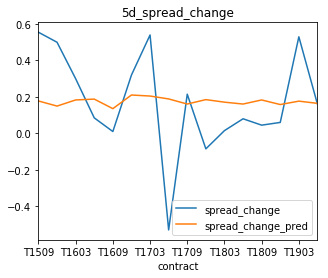

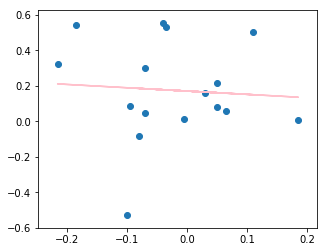

feature:  10d_act_price_exp_mva
0.08174146678637095


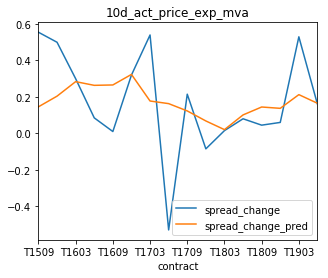

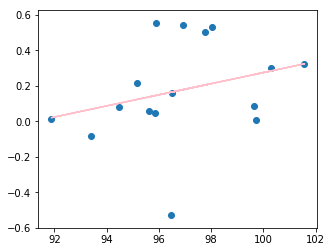

feature:  -1d_corr_act_price_def_OI
0.016555952626012616


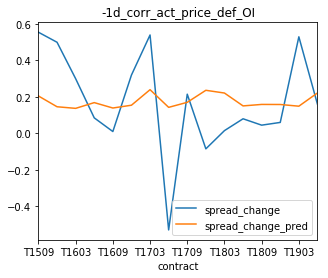

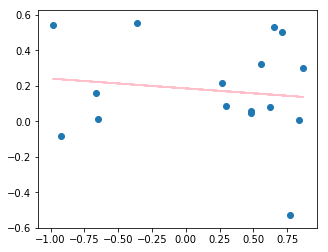

feature:  -1d_corr_def_price_def_OI
0.01931829720077527


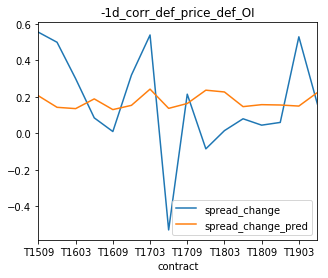

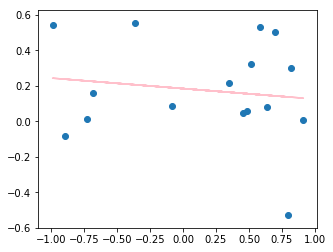

feature:  10d_spread_std_divided_by_std
0.0015785517898895263


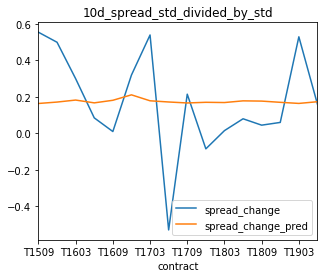

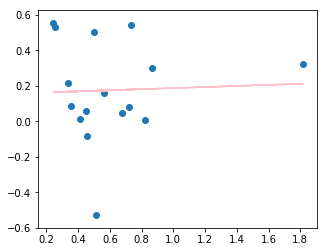

feature:  10d_current_price
0.0012721128650264868


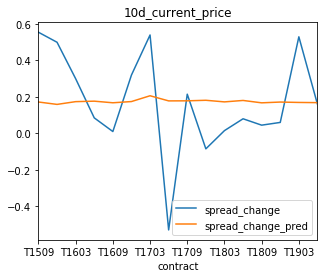

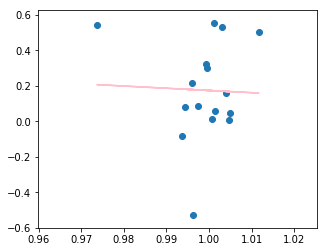

feature:  1d_z_diff_act_price_def_price
0.1666908950607775


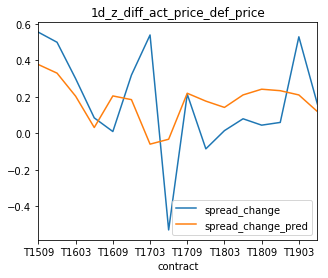

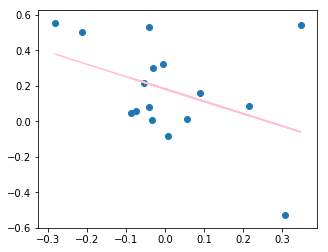

feature:  -1d_corr_act_price_def_volume
0.014353634494270517


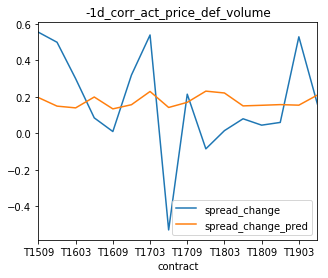

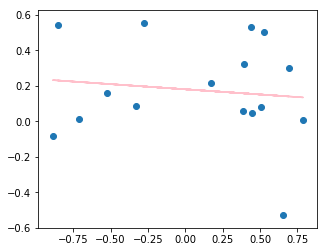

feature:  -1d_corr_def_price_def_volume
0.01558585707978122


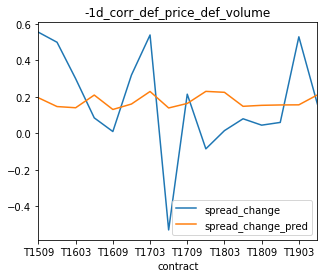

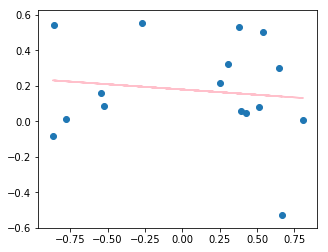

feature:  10d_current_spread
0.017892705732628356


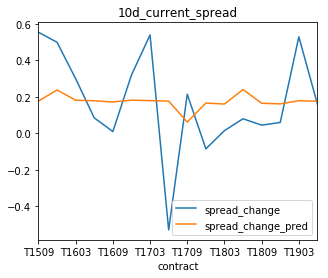

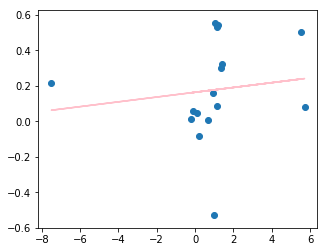

feature:  -1d_std
0.03899803248458156


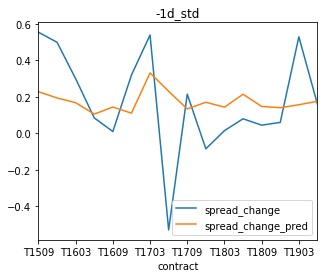

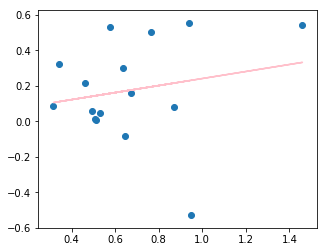

feature:  -1d_corr_act_price_def_price
0.013491533258446875


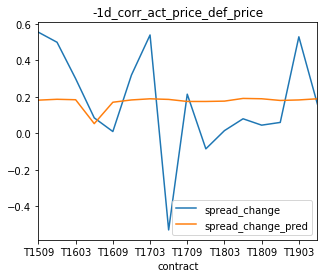

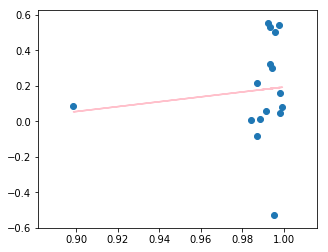

feature:  -1d_corr_act_OI_def_volume
0.006720884865607847


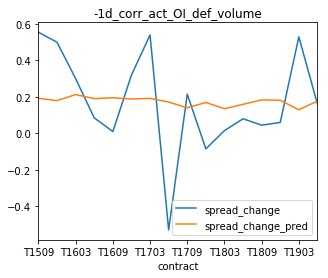

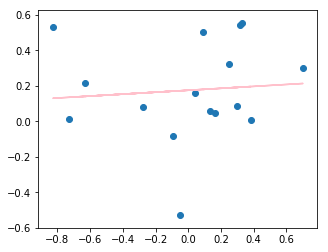

feature:  -1d_corr_act_OI_def_OI
0.0010967288240701922


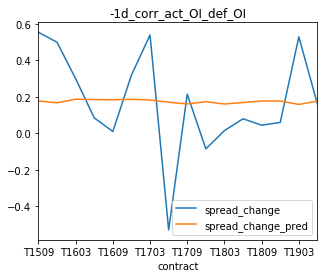

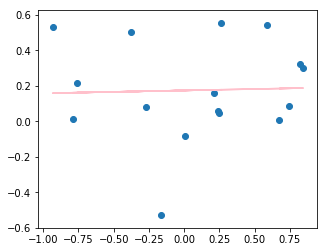

feature:  -1d_corr_def_volume_def_OI
0.009996433556656137


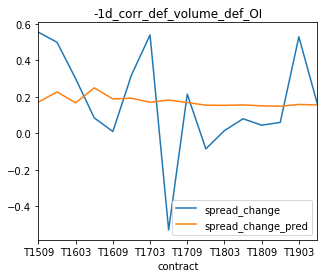

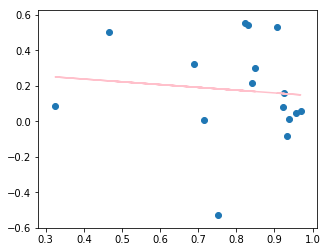

feature:  -1d_corr_def_OI_spread
0.2248521601444662


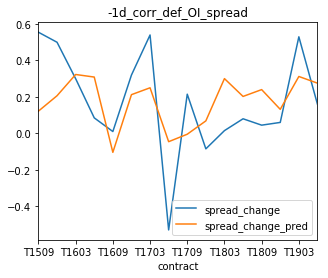

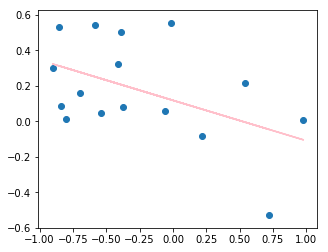

feature:  -1d_corr_def_volume_spread
0.15694937199469572


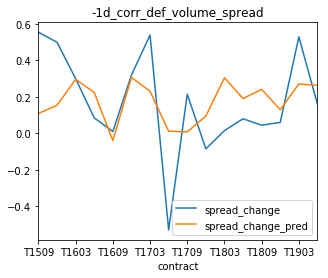

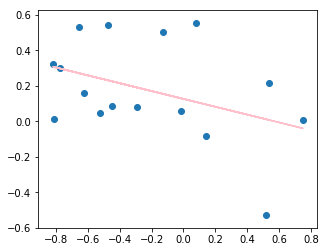

feature:  1d_z_diff_act_price_def_OI
0.10707139044465187


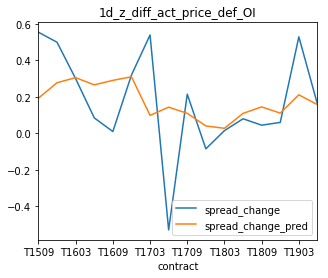

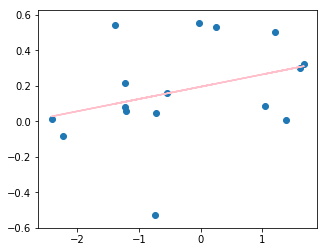

feature:  -1d_corr_act_volume_def_volume
0.003788083723607283


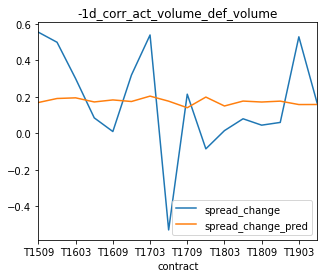

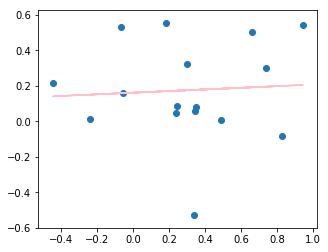

feature:  -1d_corr_act_volume_def_OI
0.03528395256102179


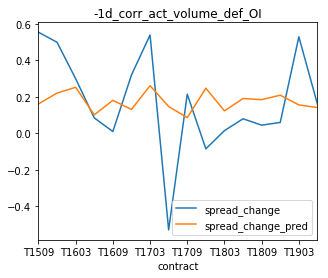

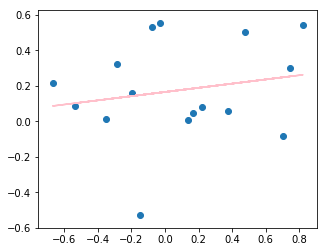

feature:  -1d_corr_act_price_act_OI
0.031178689474880894


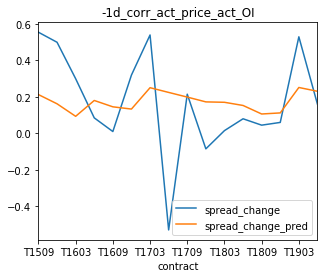

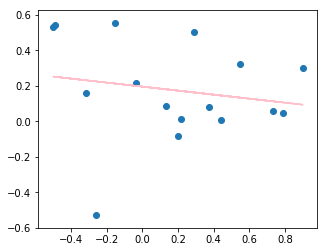

feature:  1d_z_diff_act_volume_act_OI
0.08621244641954362


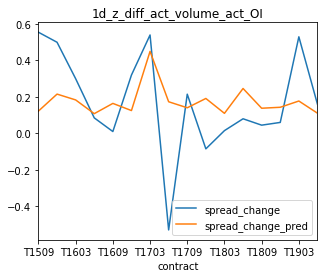

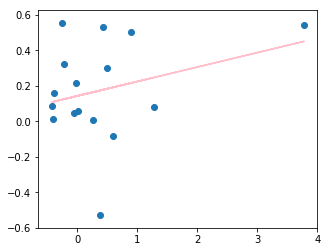

feature:  10d_def_volume_exp_mva
0.08755224925799843


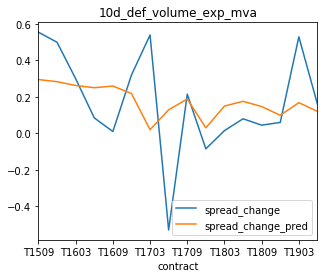

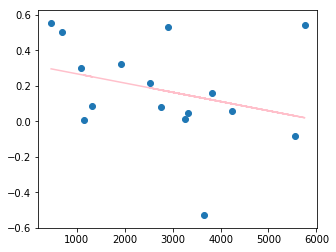

feature:  -1d_corr_act_OI_spread
0.00430894396243009


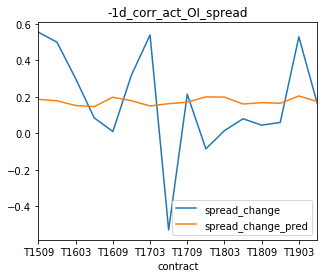

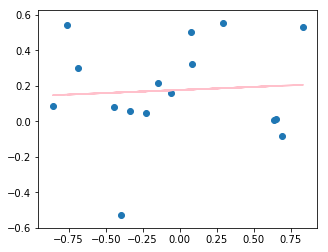

feature:  -1d_corr_def_price_spread
0.14076654740680605


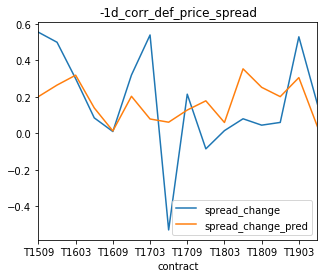

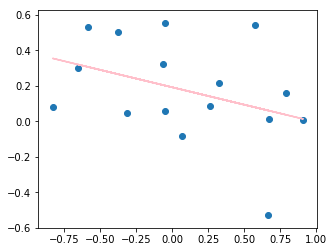

In [18]:
plt.rcParams['figure.figsize'] = [5, 4]
for feature in T_features.columns:
    print('feature: ', feature)
    x = T_features[feature].values.reshape(-1, 1)
    y = T_spread_change.values.reshape(-1, 1)
    lr = LinearRegression()
    lr.fit(x, y)
    print(lr.score(x, y))
    y_pred = lr.predict(x)
    
    reg = T_spread_change.copy()
    reg['spread_change_pred'] = y_pred
    reg[['spread_change', 'spread_change_pred']].plot()
    plt.title(feature)
    plt.show()
    plt.scatter(x,y)
    plt.plot(x, y_pred, c='pink')
    plt.show()

In [19]:
T_tscore = pd.DataFrame(index=['t_value', 'p_value'], columns=T_features.columns)

for feature in T_features.columns:
    
    print('feature: ', feature)
    x = T_features[feature].values.reshape(-1, 1)
    y = T_spread_change.values.reshape(-1, 1)
    
    X2 = sm.add_constant(x)
    est = sm.OLS(y, X2)
    est2 = est.fit()
    
    print(est2.summary())
    print()
    
    T_tscore.loc['t_value', feature] = est2.tvalues[1]
    T_tscore.loc['p_value', feature] = est2.pvalues[1]
    print()

feature:  5d_spread_change
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.066
Method:                 Least Squares   F-statistic:                   0.06671
Date:                Mon, 05 Aug 2019   Prob (F-statistic):              0.800
Time:                        10:10:47   Log-Likelihood:                -2.0254
No. Observations:                  16   AIC:                             8.051
Df Residuals:                      14   BIC:                             9.596
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1703    

D:\anaconda\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))
D:\anaconda\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))
D:\anaconda\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))
D:\anaconda\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))
D:\anaconda\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))
D:\anaconda\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))
D:\anaconda\lib\site-packages\scipy\stats\stat




feature:  10d_act_price_exp_mva
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     1.246
Date:                Mon, 05 Aug 2019   Prob (F-statistic):              0.283
Time:                        10:10:47   Log-Likelihood:                -1.3812
No. Observations:                  16   AIC:                             6.762
Df Residuals:                      14   BIC:                             8.308
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.067
Method:                 Least Squares   F-statistic:                   0.06059
Date:                Mon, 05 Aug 2019   Prob (F-statistic):              0.809
Time:                        10:10:47   Log-Likelihood:                -2.0289
No. Observations:                  16   AIC:                             8.058
Df Residuals:                      14   BIC:                             9.603
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1764      0.074      2.396      0.0

D:\anaconda\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))


In [107]:
T_tscore.to_csv('T_tscore.csv')

In [20]:
T_tscore#.loc['p_value', :]

,5d_spread_change,10d_act_price_exp_mva,-1d_corr_act_price_def_OI,-1d_corr_def_price_def_OI,10d_spread_std_divided_by_std,10d_current_price,1d_z_diff_act_price_def_price,-1d_corr_act_price_def_volume,-1d_corr_def_price_def_volume,10d_current_spread,...,-1d_corr_def_OI_spread,-1d_corr_def_volume_spread,1d_z_diff_act_price_def_OI,-1d_corr_act_volume_def_volume,-1d_corr_act_volume_def_OI,-1d_corr_act_price_act_OI,1d_z_diff_act_volume_act_OI,10d_def_volume_exp_mva,-1d_corr_act_OI_spread,-1d_corr_def_price_spread
t_value,-0.258276,1.11636,-0.485474,-0.525151,0.148777,-0.133538,-1.67347,-0.451528,-0.470804,0.505036,...,-2.01521,-1.61442,1.29566,0.230727,0.715571,-0.67123,1.14928,-1.15903,0.246143,-1.51446
p_value,0.799952,0.283064,0.634849,0.607695,0.883851,0.895669,0.116423,0.658525,0.645032,0.62139,...,0.0635005,0.128741,0.216047,0.820865,0.48602,0.512998,0.269696,0.265833,0.809144,0.152156


feature:  5d_spread_change
0.10719502141142435


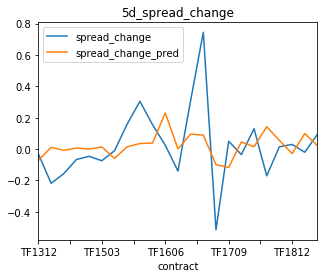

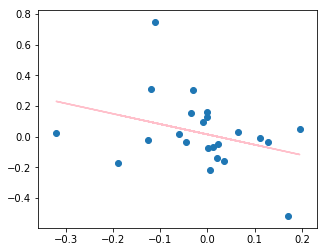

feature:  10d_act_price_exp_mva
0.11533324387773268


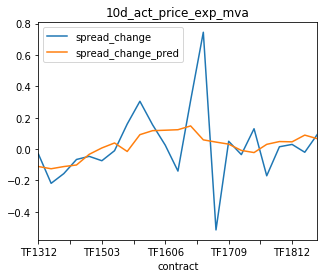

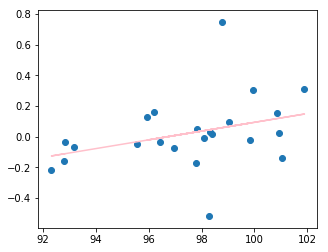

feature:  -1d_corr_act_price_def_OI
0.032013540803200735


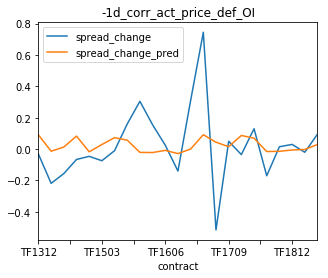

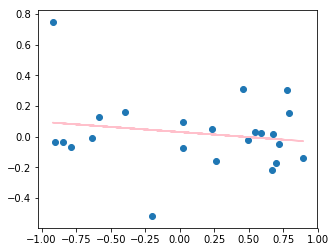

feature:  -1d_corr_def_price_def_OI
0.06006705911085042


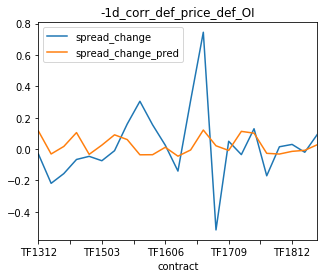

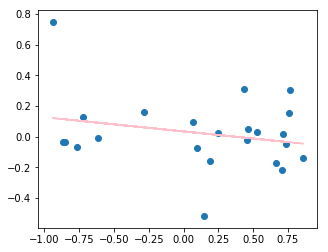

feature:  10d_spread_std_divided_by_std
0.07983583135199501


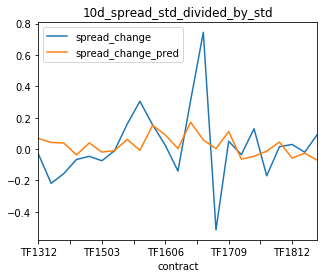

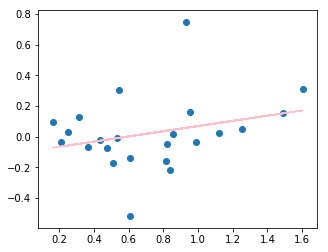

feature:  10d_current_price
0.08013145060604498


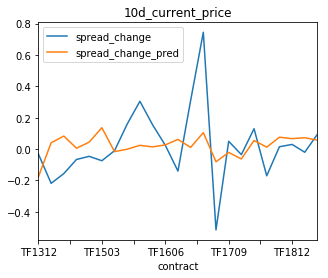

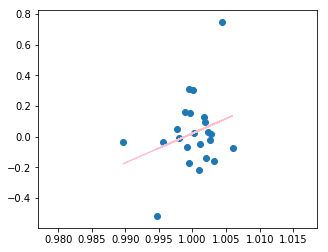

feature:  1d_z_diff_act_price_def_price
0.0013917341987743637


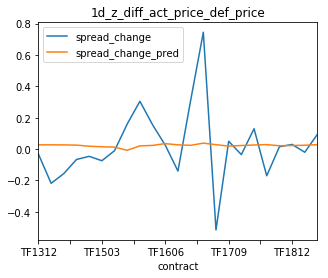

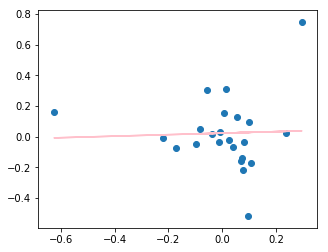

feature:  -1d_corr_act_price_def_volume
0.022912692424387426


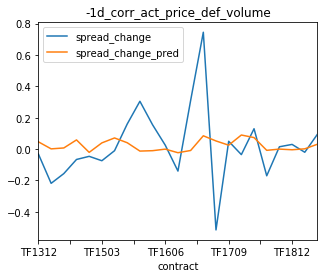

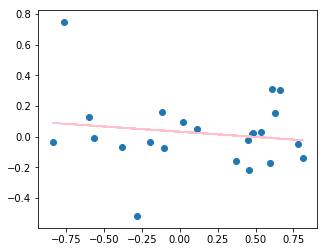

feature:  -1d_corr_def_price_def_volume
0.051019462395740844


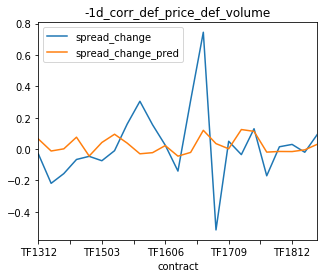

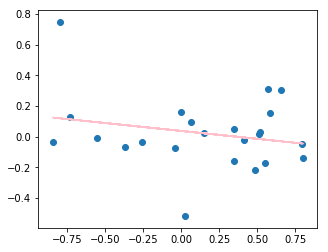

feature:  10d_current_spread
0.0696639397247355


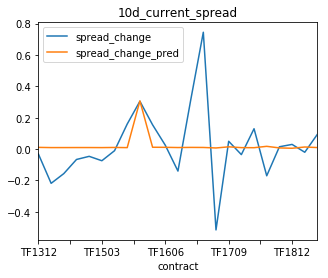

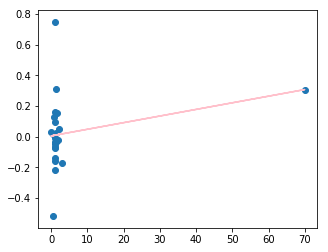

feature:  -1d_std
0.11014868907854913


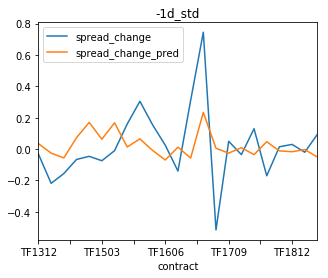

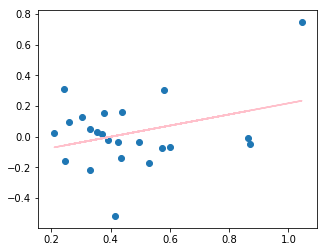

feature:  -1d_corr_act_price_def_price
0.00807440685572014


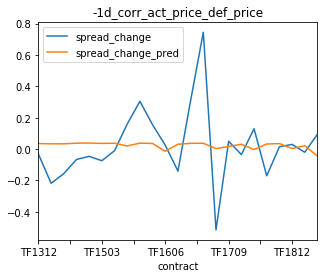

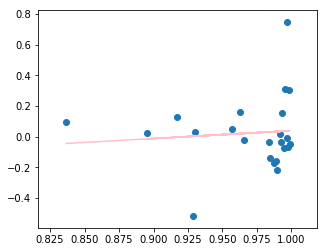

feature:  -1d_corr_act_OI_def_volume
0.0015354825567494013


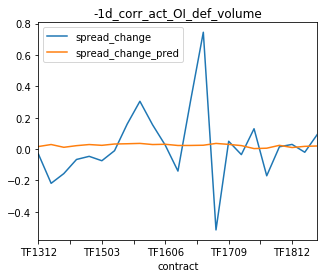

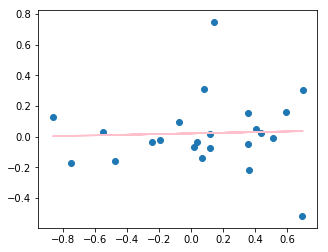

feature:  -1d_corr_act_OI_def_OI
0.006310539697918949


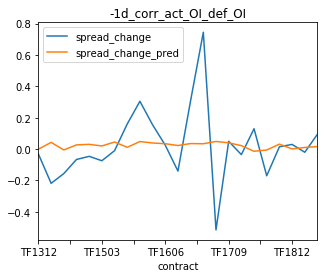

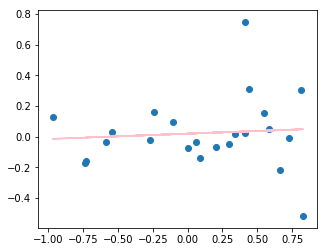

feature:  -1d_corr_def_volume_def_OI
0.006395451354069159


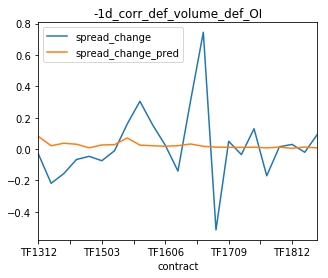

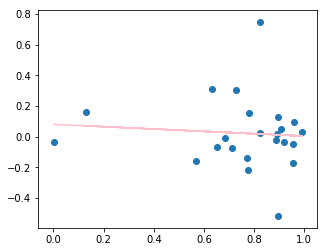

feature:  -1d_corr_def_OI_spread
0.19648539290174738


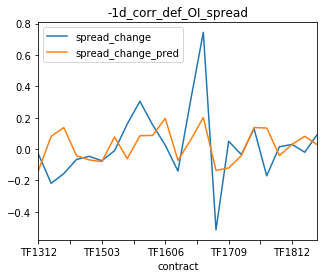

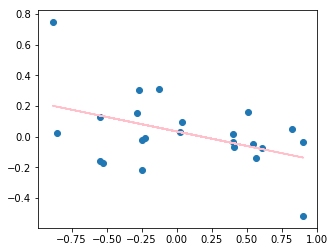

feature:  -1d_corr_def_volume_spread
0.22122592229815563


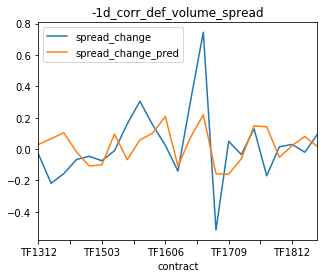

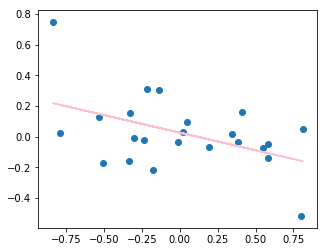

feature:  1d_z_diff_act_price_def_OI
0.10806431032281727


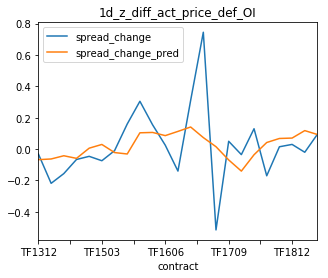

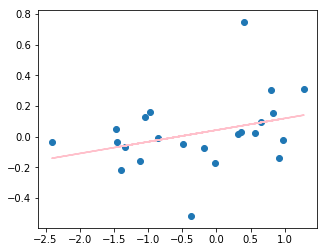

feature:  -1d_corr_act_volume_def_volume
0.0818857685733505


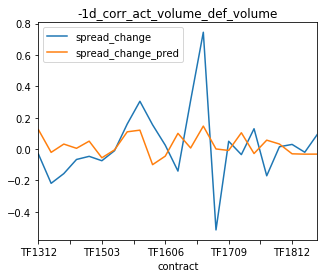

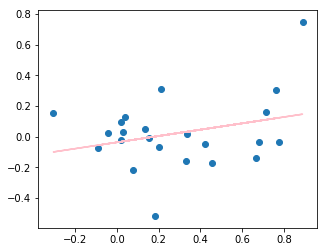

feature:  -1d_corr_act_volume_def_OI
0.12463517365172082


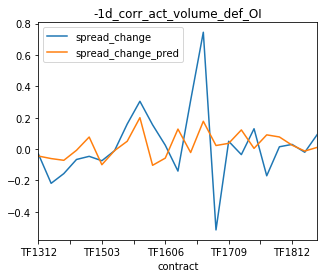

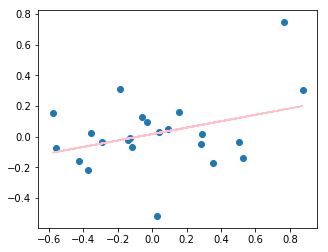

feature:  -1d_corr_act_price_act_OI
0.00853815097039956


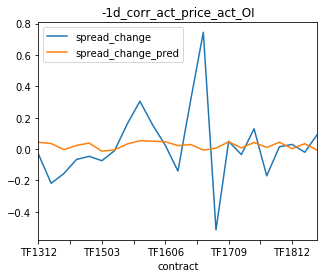

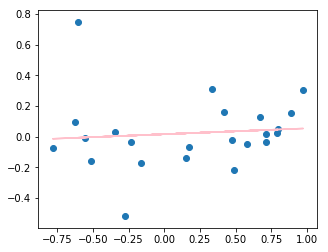

feature:  1d_z_diff_act_volume_act_OI
0.053909222810416095


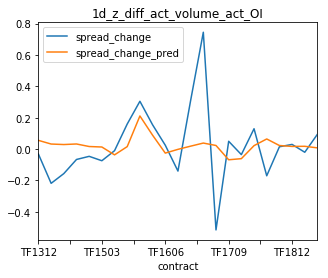

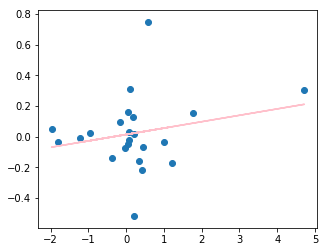

feature:  10d_def_volume_exp_mva
0.05486071921977265


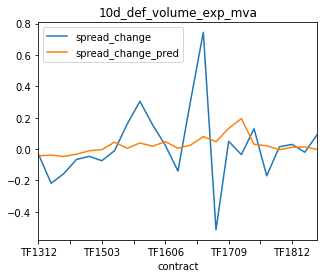

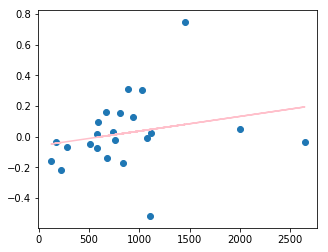

feature:  -1d_corr_act_OI_spread
0.08828241144334437


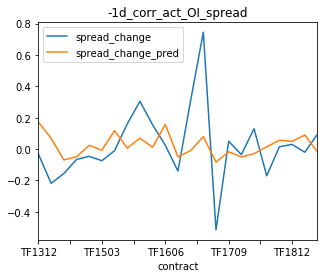

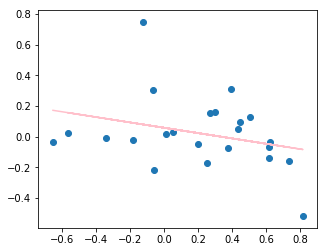

feature:  -1d_corr_def_price_spread
0.10728885274532717


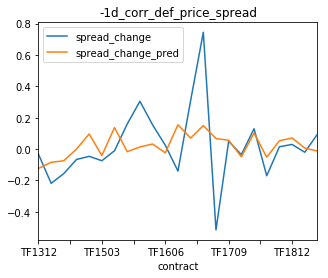

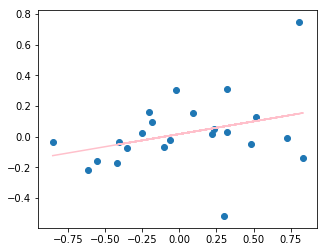

In [21]:
plt.rcParams['figure.figsize'] = [5, 4]
for feature in TF_features.columns:
    print('feature: ', feature)
    x = TF_features[feature].values.reshape(-1, 1)
    y = TF_spread_change.values.reshape(-1, 1)
    lr = LinearRegression()
    lr.fit(x, y)
    print(lr.score(x, y))
    y_pred = lr.predict(x)
    
    reg = TF_spread_change.copy()
    reg['spread_change_pred'] = y_pred
    reg[['spread_change', 'spread_change_pred']].plot()
    plt.title(feature)
    plt.show()
    plt.scatter(x,y)
    plt.plot(x, y_pred, c='pink')
    plt.show()

In [22]:
TF_tscore = pd.DataFrame(index=['t_value', 'p_value'], columns=TF_features.columns)

for feature in TF_features.columns:
    
    print('feature: ', feature)
    x = TF_features[feature].values.reshape(-1, 1)
    y = TF_spread_change.values.reshape(-1, 1)
    
    X2 = sm.add_constant(x)
    est = sm.OLS(y, X2)
    est2 = est.fit()
    
    print(est2.summary())
    print()
    
    TF_tscore.loc['t_value', feature] = est2.tvalues[1]
    TF_tscore.loc['p_value', feature] = est2.pvalues[1]
    print()

feature:  5d_spread_change
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     2.521
Date:                Mon, 05 Aug 2019   Prob (F-statistic):              0.127
Time:                        10:10:57   Log-Likelihood:                 2.5188
No. Observations:                  23   AIC:                            -1.038
Df Residuals:                      21   BIC:                             1.233
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0152    

In [111]:
TF_tscore.to_csv('TF_tscore.csv')

In [23]:
TF_tscore

,5d_spread_change,10d_act_price_exp_mva,-1d_corr_act_price_def_OI,-1d_corr_def_price_def_OI,10d_spread_std_divided_by_std,10d_current_price,1d_z_diff_act_price_def_price,-1d_corr_act_price_def_volume,-1d_corr_def_price_def_volume,10d_current_spread,...,-1d_corr_def_OI_spread,-1d_corr_def_volume_spread,1d_z_diff_act_price_def_OI,-1d_corr_act_volume_def_volume,-1d_corr_act_volume_def_OI,-1d_corr_act_price_act_OI,1d_z_diff_act_volume_act_OI,10d_def_volume_exp_mva,-1d_corr_act_OI_spread,-1d_corr_def_price_spread
t_value,-1.58788,1.65462,-0.833378,-1.15846,1.34982,1.35253,0.171076,-0.701748,-1.06255,1.25399,...,-2.26609,-2.44243,1.59509,1.36857,1.72916,0.425259,1.09389,1.10406,-1.42599,1.58866
p_value,0.127256,0.112873,0.41401,0.259683,0.191445,0.19059,0.865801,0.490541,0.300054,0.223626,...,0.0341356,0.0235181,0.125633,0.185599,0.0984549,0.674974,0.286391,0.282058,0.168568,0.12708


## Lasso Regression

In [24]:
from sklearn.linear_model import Lasso

### T

In [25]:
T_features.columns

Index(['5d_spread_change', '10d_act_price_exp_mva',
       '-1d_corr_act_price_def_OI', '-1d_corr_def_price_def_OI',
       '10d_spread_std_divided_by_std', '10d_current_price',
       '1d_z_diff_act_price_def_price', '-1d_corr_act_price_def_volume',
       '-1d_corr_def_price_def_volume', '10d_current_spread', '-1d_std',
       '-1d_corr_act_price_def_price', '-1d_corr_act_OI_def_volume',
       '-1d_corr_act_OI_def_OI', '-1d_corr_def_volume_def_OI',
       '-1d_corr_def_OI_spread', '-1d_corr_def_volume_spread',
       '1d_z_diff_act_price_def_OI', '-1d_corr_act_volume_def_volume',
       '-1d_corr_act_volume_def_OI', '-1d_corr_act_price_act_OI',
       '1d_z_diff_act_volume_act_OI', '10d_def_volume_exp_mva',
       '-1d_corr_act_OI_spread', '-1d_corr_def_price_spread'],
      dtype='object')

In [26]:
x = T_features.values
y = T_spread_change.values

alphas = [0.001, 0.002, 0.005, 0.01, 0.015, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10]
for alpha in alphas:
    lasso = Lasso(alpha=alpha, normalize=True)
    lasso.fit(x, y)
    print(alpha, '-------', lasso.score(x, y))
    print(lasso.sparse_coef_)
    print()
    #print(np.count_nonzero(lasso.sparse_coef_.toarray()))

0.001 ------- 0.9838849656960682
  (0, 1)	0.056523705037305444
  (0, 5)	-0.23118381259489845
  (0, 6)	-1.4975101366231691
  (0, 8)	-0.13684909526069142
  (0, 9)	-0.01573636371647679
  (0, 15)	-0.1860614387312877
  (0, 18)	-0.1442116932786641
  (0, 20)	-0.14486144336304158
  (0, 21)	0.19009173004513827
  (0, 22)	-8.781012895322532e-06
  (0, 24)	0.02296170022330635

0.002 ------- 0.9683978282143477
  (0, 1)	0.050148799551640956
  (0, 3)	-0.031885672613575854
  (0, 6)	-1.3596429289187295
  (0, 8)	-0.08391103292656218
  (0, 9)	-0.016337921048222615
  (0, 15)	-0.1843511421758803
  (0, 18)	-0.08502301091808671
  (0, 20)	-0.15995657456804818
  (0, 21)	0.16412180493160142
  (0, 22)	-1.0608284062925257e-05

0.005 ------- 0.8932568745332453
  (0, 1)	0.036308408050892534
  (0, 3)	-0.039440905968201115
  (0, 6)	-1.1392627299916962
  (0, 7)	-0.013611900439285556
  (0, 9)	-0.010477951574390066
  (0, 15)	-0.18596751862125668
  (0, 20)	-0.16897024044229458
  (0, 21)	0.11197702387391827
  (0, 22)	-3.72

In [27]:
T_tscore.iloc[:, 6]

t_value    -1.67347
p_value    0.116423
Name: 1d_z_diff_act_price_def_price, dtype: object

In [28]:
T_tscore.iloc[:, 15]

t_value     -2.01521
p_value    0.0635005
Name: -1d_corr_def_OI_spread, dtype: object

In [29]:
T_tscore.iloc[:, 21]

t_value     1.14928
p_value    0.269696
Name: 1d_z_diff_act_volume_act_OI, dtype: object

In [40]:
T_features.iloc[:, [15, 16]].corr()

,-1d_corr_def_OI_spread,-1d_corr_def_volume_spread
-1d_corr_def_OI_spread,1.000000,0.949488
-1d_corr_def_volume_spread,0.949488,1.000000


In [63]:
x = T_features.iloc[:, 15].values
y = T_spread_change.values

X2 = sm.add_constant(x)
est = sm.OLS(y, X2)
est2 = est.fit()

print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.225
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     4.061
Date:                Mon, 05 Aug 2019   Prob (F-statistic):             0.0635
Time:                        11:08:47   Log-Likelihood:              -0.025840
No. Observations:                  16   AIC:                             4.052
Df Residuals:                      14   BIC:                             5.597
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1180      0.071      1.669      0.1

D:\anaconda\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))


### TF

In [32]:
TF_tscore.iloc[:, 10]

t_value     1.61228
p_value    0.121829
Name: -1d_std, dtype: object

In [33]:
TF_tscore.iloc[:, 16]

t_value     -2.44243
p_value    0.0235181
Name: -1d_corr_def_volume_spread, dtype: object

In [34]:
TF_tscore.iloc[:, 19]

t_value      1.72916
p_value    0.0984549
Name: -1d_corr_act_volume_def_OI, dtype: object

In [41]:
np.corrcoef(TF_features.iloc[:, 15].values, TF_features.iloc[:, 16].values)

array([[1.        , 0.92753111],
       [0.92753111, 1.        ]])

In [36]:
TF_tscore.iloc[:, 24]

t_value    1.58866
p_value    0.12708
Name: -1d_corr_def_price_spread, dtype: object

In [37]:
x = TF_features.values
y = TF_spread_change.values

alphas = [0.001, 0.002, 0.005, 0.01, 0.015, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10]
for alpha in alphas:
    lasso = Lasso(alpha=alpha, normalize=True)
    lasso.fit(x, y)
    print(alpha, '-------', lasso.score(x, y))
    print(lasso.sparse_coef_)
    print()
    #print(np.count_nonzero(lasso.sparse_coef_.toarray()))

0.001 ------- 0.883094645073995
  (0, 0)	0.1001255242213365
  (0, 3)	-0.24592387096555401
  (0, 4)	0.3505917290055181
  (0, 5)	34.483516686102725
  (0, 6)	-0.1528669387721796
  (0, 9)	0.0023233843768498
  (0, 11)	-0.5114412167114645
  (0, 12)	-0.08181342112956524
  (0, 16)	-0.017271073170227726
  (0, 17)	0.05427301510545437
  (0, 19)	0.18288959438537353
  (0, 20)	0.00927545235006376
  (0, 21)	0.027075392974402306
  (0, 22)	8.115672038541048e-05
  (0, 23)	-0.10414092643198279

0.002 ------- 0.8369199803052401
  (0, 3)	-0.21714753535535863
  (0, 4)	0.28685424415280125
  (0, 5)	27.98145411156218
  (0, 6)	-0.09451263089179883
  (0, 9)	0.0025012856873022522
  (0, 11)	-0.0894333776951601
  (0, 12)	-0.03042526291491146
  (0, 16)	-0.04895563315437624
  (0, 17)	0.05263258892323626
  (0, 19)	0.1740497760235662
  (0, 20)	0.006000085416761035
  (0, 21)	0.008486145698341692
  (0, 22)	4.8027308651933994e-05
  (0, 23)	-0.06369405062371394

0.005 ------- 0.7059726910982358
  (0, 1)	0.00758635977730910

In [64]:
x = TF_features.iloc[:, 15].values # 1, 11, 17, 20, 25
y = TF_spread_change.values

X2 = sm.add_constant(x)
est = sm.OLS(y, X2)
est2 = est.fit()

print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     5.135
Date:                Mon, 05 Aug 2019   Prob (F-statistic):             0.0341
Time:                        11:09:17   Log-Likelihood:                 3.7306
No. Observations:                  23   AIC:                            -3.461
Df Residuals:                      21   BIC:                            -1.190
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0346      0.045      0.766      0.4

In [39]:
x = TF_features.iloc[:, [16, 24]].values # 1, 11, 17, 20, 25
y = TF_spread_change.values

X2 = sm.add_constant(x)
est = sm.OLS(y, X2)
est2 = est.fit()

print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.347
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     5.313
Date:                Mon, 05 Aug 2019   Prob (F-statistic):             0.0141
Time:                        10:11:41   Log-Likelihood:                 6.1155
No. Observations:                  23   AIC:                            -6.231
Df Residuals:                      20   BIC:                            -2.825
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0202      0.042      0.485      0.6

## Return

In [72]:
import pyfolio as pf

D:\anaconda\lib\site-packages\pyfolio\pos.py:28: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  ' to position notionals.'
WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
D:\anaconda\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [45]:
T_spread_price

,active_contract,deferred_contract,active_contract_price,deferred_contract_price,spread_price
Trading_Day,,,,,
2015-03-20,T1509,T1512,97.090,97.435,-0.345
2015-03-23,T1509,T1512,97.020,97.435,-0.415
2015-03-24,T1509,T1512,96.920,97.435,-0.515
2015-03-25,T1509,T1512,96.850,97.500,-0.650
2015-03-26,T1509,T1512,96.370,97.000,-0.630
2015-03-27,T1509,T1512,96.490,96.835,-0.345
2015-03-30,T1509,T1512,96.160,96.675,-0.515
2015-03-31,T1509,T1512,95.650,96.145,-0.495
2015-04-01,T1509,T1512,96.095,96.145,-0.050


In [57]:
T_spread_return_acc = T_roll_period.shift(-1).dropna().copy()
T_spread_return_acc['spread_return'] = None

for active_contract in T_spread_return_acc.index:
    

    signal = -np.sign(T_features.loc[active_contract, '-1d_corr_def_OI_spread'])
    
    start_date = T_spread_return_acc.loc[active_contract, 'start']
    end_date = T_spread_return_acc.loc[active_contract, 'end']
    
    active_change = T_spread_price.loc[end_date, 'active_contract_price'] - T_spread_price.loc[start_date, 'active_contract_price']
    deferred_change = T_spread_price.loc[start_date, 'deferred_contract_price'] - T_spread_price.loc[end_date, 'deferred_contract_price']
    ret = signal * (active_change + deferred_change)/ (T_spread_price.loc[start_date, 'active_contract_price'] + T_spread_price.loc[start_date, 'deferred_contract_price'])
    T_spread_return_acc.loc[active_contract, 'spread_return'] = ret


In [66]:
(T_spread_return_acc['spread_return'] * 5 + 1).cumprod()

contract
T1509    1.01442
T1512    1.02726
T1603    1.03495
T1606    1.03717
T1609    1.03691
T1612    1.04511
T1703     1.0601
T1706    1.07477
T1709    1.06868
T1712    1.07112
T1803    1.07156
T1806    1.07384
T1809    1.07509
T1812    1.07677
T1903    1.09132
T1906    1.09584
Name: spread_return, dtype: object

In [60]:
TF_spread_return_acc = TF_roll_period.shift(-1).dropna().copy()
TF_spread_return_acc['spread_return'] = None

for active_contract in TF_spread_return_acc.index:
    

    signal = -np.sign(TF_features.loc[active_contract, '-1d_corr_def_OI_spread'])
    
    start_date = TF_spread_return_acc.loc[active_contract, 'start']
    end_date = TF_spread_return_acc.loc[active_contract, 'end']
    
    active_change = TF_spread_price.loc[end_date, 'active_contract_price'] - TF_spread_price.loc[start_date, 'active_contract_price']
    deferred_change = TF_spread_price.loc[start_date, 'deferred_contract_price'] - TF_spread_price.loc[end_date, 'deferred_contract_price']
    ret = signal * (active_change + deferred_change)/ (TF_spread_price.loc[start_date, 'active_contract_price'] + TF_spread_price.loc[start_date, 'deferred_contract_price'])
    TF_spread_return_acc.loc[active_contract, 'spread_return'] = ret


In [62]:
TF_spread_return_acc

,start,end,spread_return
contract,,,
TF1312,2013-11-12,2013-12-04,0.000173312
TF1403,2014-02-12,2014-02-25,-0.00117642
TF1406,2014-05-08,2014-05-19,-0.000836596
TF1409,2014-08-06,2014-08-15,0.000353774
TF1412,2014-10-29,2014-11-07,0.000239561
TF1503,2015-01-16,2015-02-09,0.000378706
TF1506,2015-05-05,2015-05-22,-5.08686e-05
TF1509,2015-06-25,2015-08-25,-0.000825934
TF1512,2015-10-23,2015-11-23,0.00152443


In [65]:
(TF_spread_return_acc['spread_return'] * 5 + 1).cumprod()

contract
TF1312     1.00087
TF1403    0.994979
TF1406    0.990817
TF1409     0.99257
TF1412    0.993759
TF1503    0.995641
TF1506    0.995387
TF1509    0.991277
TF1512    0.998832
TF1603     1.00268
TF1606      1.0033
TF1609     1.00678
TF1612     1.01445
TF1703     1.03362
TF1706     1.04724
TF1709      1.0459
TF1712     1.04686
TF1803      1.0504
TF1806     1.04583
TF1809     1.04543
TF1812     1.04463
TF1903     1.04411
TF1906     1.04161
Name: spread_return, dtype: object

In [68]:
T_spread_return = T_spread_price.copy()
T_spread_return['spread_price_ret'] = T_spread_return['spread_price'].diff() / 200
T_spread_return = T_spread_return.dropna()
T_spread_return['spread_return'] = None

for active_contract in T_roll_period.shift(-1).dropna().index:
    
    deferred_contract = find_next_contract(active_contract, T_contract_list)
    signal = -np.sign(T_features.loc[active_contract, '-1d_corr_def_OI_spread'])
    
    start_date = T_roll_period.loc[deferred_contract, 'start']
    day_after_start = T_spread_price[start_date:].index[1]
    end_date = T_roll_period.loc[deferred_contract, 'end']
    
    ret = T_spread_return.loc[day_after_start:end_date, 'spread_price_ret'] * signal
    T_spread_return.loc[day_after_start:end_date, 'spread_return'] = ret


In [70]:
TF_spread_return = TF_spread_price.copy()
TF_spread_return['spread_price_ret'] = TF_spread_return['spread_price'].diff() / 200
TF_spread_return = TF_spread_return.dropna()
TF_spread_return['spread_return'] = None

for active_contract in TF_roll_period.shift(-1).dropna().index:
    
    deferred_contract = find_next_contract(active_contract, TF_contract_list)
    signal = -np.sign(TF_features.loc[active_contract, '-1d_corr_def_OI_spread'])
    
    start_date = TF_roll_period.loc[deferred_contract, 'start']
    day_after_start = TF_spread_price[start_date:].index[1]
    end_date = TF_roll_period.loc[deferred_contract, 'end']
    
    ret = TF_spread_return.loc[day_after_start:end_date, 'spread_price_ret'] * signal
    TF_spread_return.loc[day_after_start:end_date, 'spread_return'] = ret

Start date,2015-03-23
End date,2019-07-15
Total months,50
,Backtest
Annual return,0.4%
Cumulative returns,1.8%
Annual volatility,0.3%
Sharpe ratio,1.32
Calmar ratio,0.96
Stability,0.90
Max drawdown,-0.4%


D:\anaconda\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,0.44,2016-04-25,2016-07-04,2016-12-19,171
1,0.25,2017-02-06,2017-02-09,2017-05-15,71
2,0.23,2017-01-04,2017-01-10,2017-02-03,23
3,0.20,2017-08-01,2017-11-03,2018-08-06,265
4,0.15,2016-12-19,2016-12-21,2017-01-03,12


D:\anaconda\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


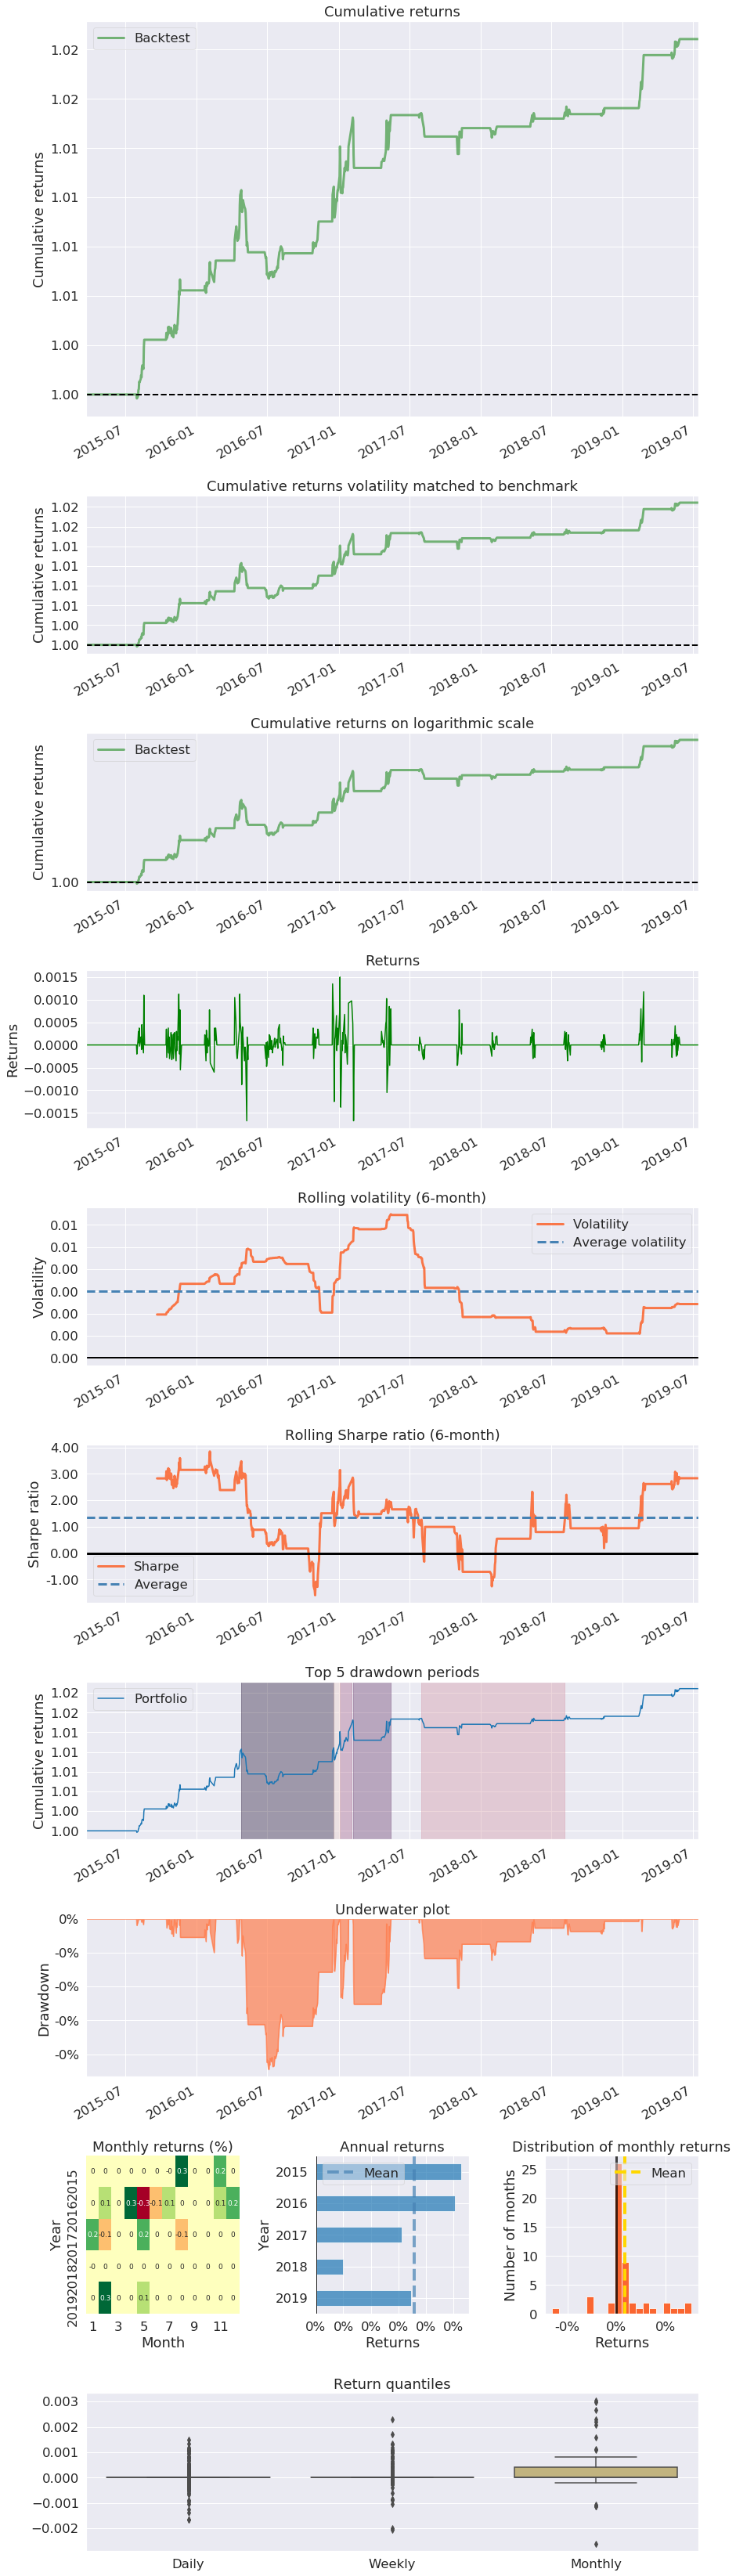

In [73]:
pf.create_returns_tear_sheet(T_spread_return['spread_return'].fillna(0))

Start date,2013-09-09
End date,2019-07-15
Total months,67
,Backtest
Annual return,0.1%
Cumulative returns,0.8%
Annual volatility,0.2%
Sharpe ratio,0.59
Calmar ratio,0.37
Stability,0.81
Max drawdown,-0.4%


D:\anaconda\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,0.39,2013-12-02,2015-08-19,2016-04-21,624
1,0.19,2018-02-12,2019-05-28,NaT,NaN
2,0.15,2016-04-25,2016-04-28,2016-11-10,144
3,0.10,2017-01-05,2017-01-12,2017-01-26,16
4,0.08,2013-11-14,2013-11-19,2013-11-20,5


D:\anaconda\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


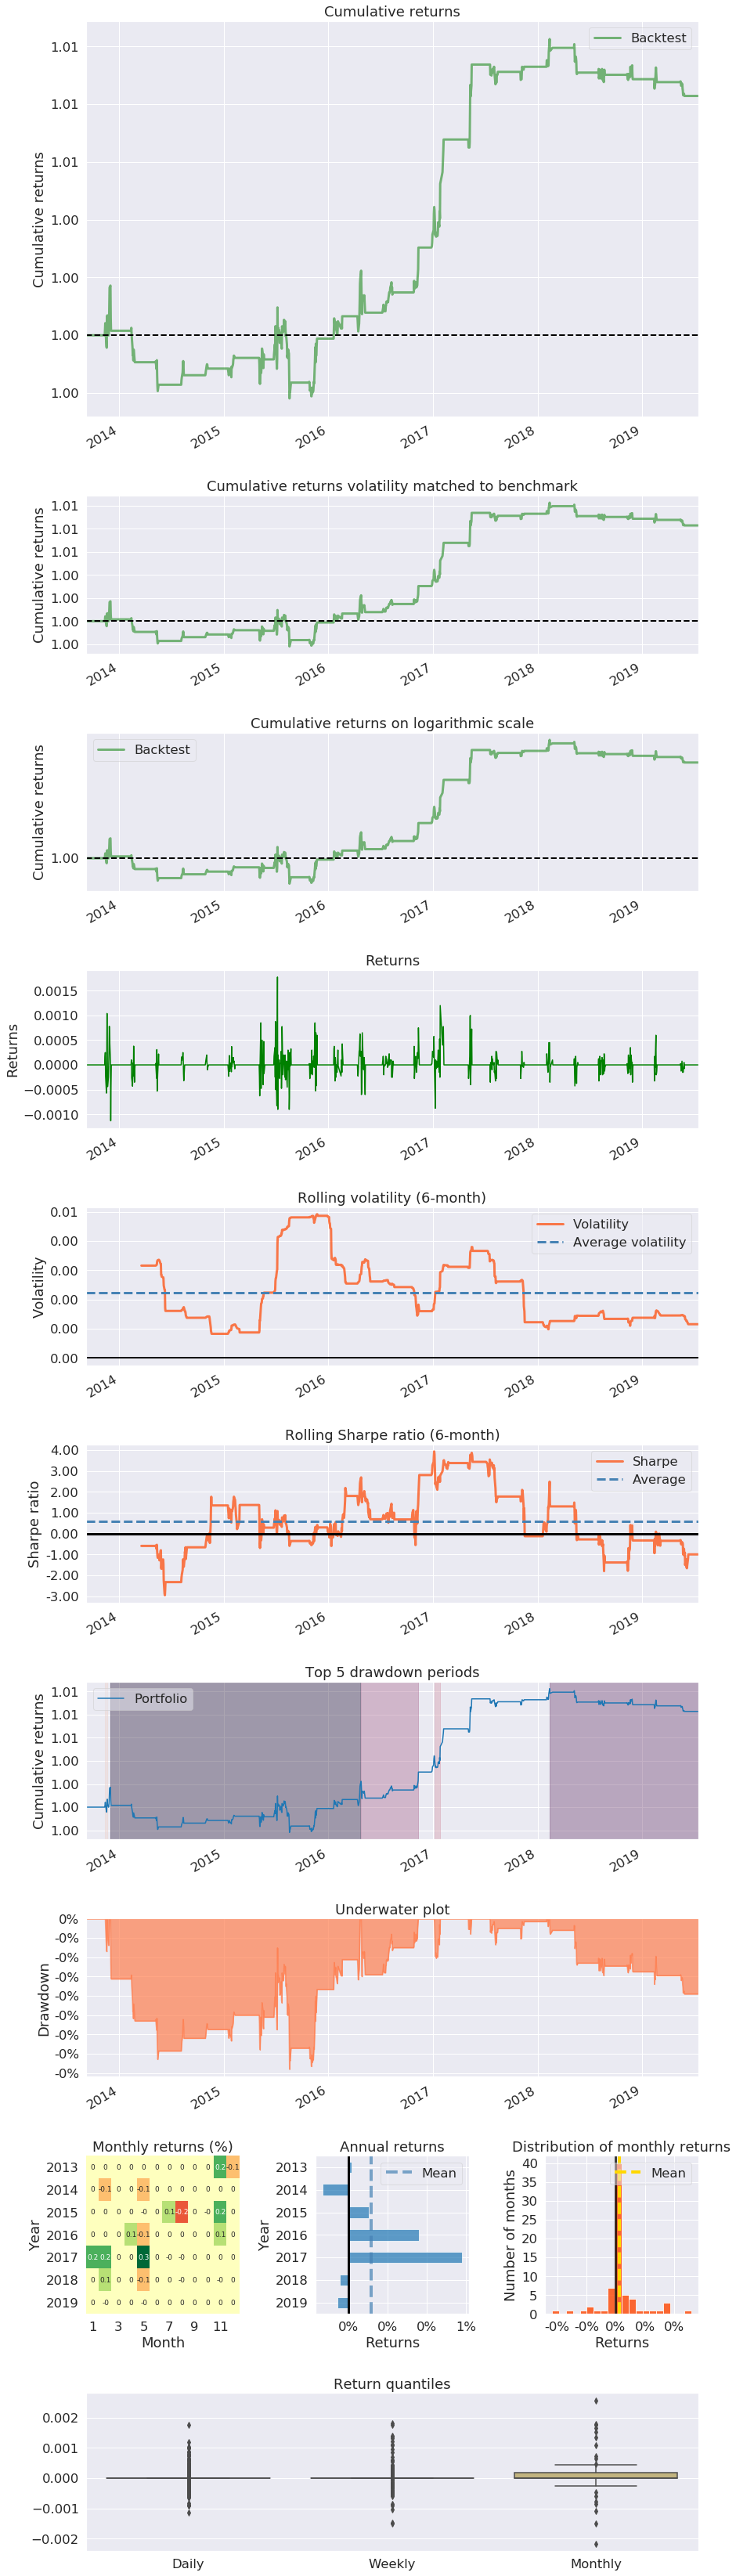

In [74]:
pf.create_returns_tear_sheet(TF_spread_return['spread_return'].fillna(0))

In [75]:
def drawdown(nav):
    running_max = nav.expanding(min_periods=1).max()
    cur_dd = (nav - running_max)/running_max
    max_dd=-cur_dd.min()
    return max_dd

In [76]:
def median_skew(ret):
    return 3*(ret.mean()-ret.median())/ret.std()

In [77]:
def grading_(portfolio_ret, single=False, holding_days = 1):
    # the return column is daily return by default

    mul_factor = 252 / holding_days

    portfolio_ret = portfolio_ret.dropna()

    if len(portfolio_ret) == 0:
        return None, None, None

    if single:
        annual_return = portfolio_ret.mean() * mul_factor
    else:
        
        nav = (1+portfolio_ret).cumprod()
        annual_return = nav.iloc[-1]**(mul_factor/len(nav))-1
    
    annual_vol = portfolio_ret.std()*np.sqrt(mul_factor)
    sharpe_ratio = annual_return/annual_vol
    max_dd = drawdown(nav)
    normalized_drawdown=max_dd/annual_vol
    sr = (stats.mstats.gmean(1+portfolio_ret)-1)/portfolio_ret.std()
    skew = median_skew(portfolio_ret)
    adj_sr = sr/np.sqrt(1-portfolio_ret.skew()*sr+((portfolio_ret.kurtosis()-1)/4)*(sr**2))*np.sqrt(mul_factor)
    # Visualization
    nav.plot(legend=True)

    print('{0:.3f}'.format(sharpe_ratio), '{0:.3f}'.format(annual_return), '{0:.3f}'.format(annual_vol),\
          '{0:.3f}'.format(max_dd), '{0:.3f}'.format(normalized_drawdown), '{0:.3f}'.format(skew), '{0:.3f}'.format(adj_sr))

    return annual_return, annual_vol, sharpe_ratio

2.680 0.017 0.006 0.004 0.694 -0.055 2.564


(0.017146257667982612, 0.006398540383513358, 2.6797139097788767)

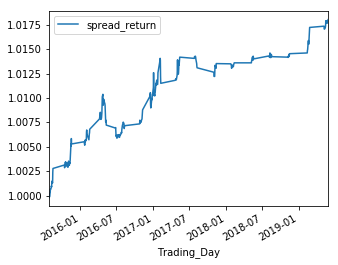

In [78]:
grading_(T_spread_return['spread_return'].dropna().astype(float))

1.196 0.006 0.005 0.004 0.767 -0.008 1.222


(0.00608136775037349, 0.005086155890263777, 1.1956707347517221)

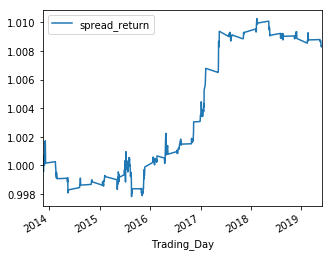

In [79]:
grading_(TF_spread_return['spread_return'].dropna().astype(float))